In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

/tmp/ipykernel_46062/1488639637.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


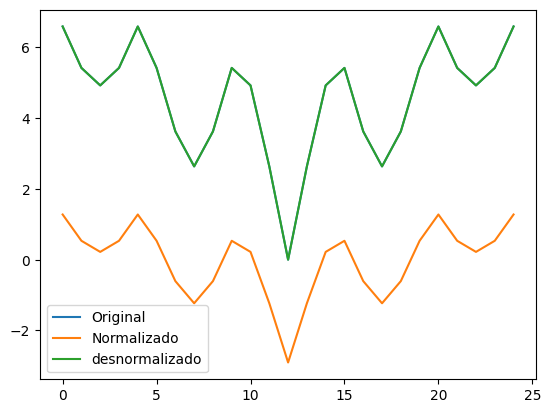

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)

In [4]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 1.74 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [5]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:39:22.418000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:39:22.418051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:39:22.419368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:39:22.457928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:39:30.884184: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 41ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_0,0.800015,0.109865,-1.154237,0.666726,0.496670,1.784445,1.588562,1.357617,4.414848e+14,0.704748,0.314337,0.734751,35.399660,56.120549
model_1_3_1,0.802722,0.106688,-1.158105,0.669494,0.489948,1.790813,1.591415,1.346343,4.400123e+14,0.699963,0.323617,0.729762,35.426912,56.147802
model_1_3_2,0.805376,0.103512,-1.162003,0.672212,0.483356,1.797181,1.594289,1.335271,4.385548e+14,0.695238,0.332718,0.724836,35.454005,56.174894
model_1_3_3,0.807980,0.100335,-1.165927,0.674883,0.476889,1.803548,1.597183,1.324388,4.371117e+14,0.690571,0.341646,0.719970,35.480945,56.201834
model_1_3_4,0.810534,0.097160,-1.169875,0.677509,0.470544,1.809914,1.600094,1.313693,4.356833e+14,0.685962,0.350404,0.715165,35.507730,56.228619
model_1_3_5,0.813040,0.093987,-1.173849,0.680089,0.464321,1.816275,1.603025,1.303182,4.342689e+14,0.681411,0.358995,0.710420,35.534357,56.255246
model_1_3_6,0.815499,0.090816,-1.177844,0.682625,0.458216,1.822631,1.605970,1.292850,4.328685e+14,0.676916,0.367424,0.705734,35.560831,56.281720
model_1_3_7,0.817910,0.087649,-1.181859,0.685117,0.452227,1.828980,1.608931,1.282700,4.314823e+14,0.672478,0.375691,0.701107,35.587141,56.308030


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_0,0.821134,0.085632,-1.187410,0.860310,0.444220,1.833023,1.613025,0.067691,4.285710e+14,0.666498,0.386745,0.694872,35.622871,56.343760
model_1_4_1,0.824294,0.083574,-1.193073,0.865478,0.436371,1.837149,1.617200,0.065187,4.256850e+14,0.660584,0.397581,0.688706,35.658524,56.379413
model_1_4_2,0.827391,0.081482,-1.198831,0.870456,0.428680,1.841343,1.621446,0.062774,4.228255e+14,0.654737,0.408198,0.682610,35.694087,56.414976
model_1_4_3,0.830426,0.079356,-1.204685,0.875249,0.421144,1.845605,1.625763,0.060452,4.199924e+14,0.648956,0.418602,0.676584,35.729560,56.450449
model_1_4_4,0.833399,0.077199,-1.210626,0.879862,0.413760,1.849929,1.630145,0.058216,4.171852e+14,0.643242,0.428796,0.670626,35.764938,56.485827
model_1_4_5,0.836313,0.075008,-1.216661,0.884298,0.406523,1.854322,1.634595,0.056067,4.144033e+14,0.637592,0.438786,0.664736,35.800227,56.521116
model_1_4_6,0.839168,0.072785,-1.222784,0.888564,0.399432,1.858778,1.639110,0.054000,4.116460e+14,0.632006,0.448577,0.658912,35.835425,56.556314
model_1_4_7,0.841966,0.070533,-1.228987,0.892662,0.392483,1.863293,1.643684,0.052014,4.089141e+14,0.626485,0.458169,0.653156,35.870523,56.591412
model_1_4_8,0.844708,0.068251,-1.235270,0.896598,0.385674,1.867867,1.648317,0.050106,4.062069e+14,0.621027,0.467569,0.647465,35.905526,56.626415
model_1_4_9,0.847394,0.065942,-1.241632,0.900376,0.379002,1.872497,1.653008,0.048276,4.035238e+14,0.615631,0.476781,0.641840,35.940430,56.661319


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.848925,0.063367,-1.243402,0.585395,0.375199,1.877658,1.654313,1.279372,4.029014e+14,0.612535,0.482030,0.638612,35.960596,56.681485
model_1_5_1,0.850426,0.060803,-1.245178,0.587599,0.371473,1.882798,1.655624,1.272573,4.022917e+14,0.609486,0.487174,0.635433,35.980559,56.701448
model_1_5_2,0.851896,0.058247,-1.246963,0.589756,0.367822,1.887923,1.656939,1.265917,4.016954e+14,0.606483,0.492215,0.632302,36.000313,56.721202
model_1_5_3,0.853337,0.055704,-1.248747,0.591869,0.364243,1.893021,1.658255,1.259395,4.011111e+14,0.603526,0.497155,0.629219,36.019866,56.740755
model_1_5_4,0.854748,0.053170,-1.250535,0.593938,0.360737,1.898100,1.659574,1.253011,4.005401e+14,0.600614,0.501995,0.626184,36.039210,56.760099
model_1_5_5,0.856132,0.050649,-1.252324,0.595964,0.357302,1.903155,1.660893,1.246761,3.999815e+14,0.597748,0.506737,0.623195,36.058346,56.779235
model_1_5_6,0.857487,0.048141,-1.254110,0.597947,0.353937,1.908183,1.662210,1.240641,3.994354e+14,0.594926,0.511383,0.620253,36.077274,56.798163
model_1_5_7,0.858814,0.045642,-1.255898,0.599886,0.350641,1.913192,1.663528,1.234657,3.989023e+14,0.592149,0.515933,0.617358,36.095987,56.816876
model_1_5_8,0.860114,0.043157,-1.257679,0.601783,0.347412,1.918173,1.664842,1.228803,3.983820e+14,0.589417,0.520390,0.614510,36.114486,56.835375
model_1_5_9,0.861387,0.040690,-1.259450,0.603639,0.344250,1.923118,1.666148,1.223076,3.978740e+14,0.586728,0.524756,0.611706,36.132775,56.853664


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_6] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.871107,0.029785,-1.299531,0.909050,0.320109,1.944979,1.695704,0.154297,3.869821e+14,0.565782,0.558083,0.589869,36.278185,56.999074
model_1_6_1,0.873407,0.026991,-1.309585,0.911880,0.314398,1.950582,1.703118,0.149495,3.843266e+14,0.560712,0.565967,0.584583,36.314190,57.035079
model_1_6_2,0.875656,0.024172,-1.319646,0.914613,0.308812,1.956232,1.710537,0.144859,3.816977e+14,0.555708,0.573679,0.579366,36.350046,57.070935
model_1_6_3,0.877857,0.021331,-1.329715,0.917251,0.303347,1.961927,1.717962,0.140383,3.790948e+14,0.550770,0.581223,0.574217,36.385755,57.106644
model_1_6_4,0.880009,0.018470,-1.339791,0.919797,0.298003,1.967664,1.725393,0.136065,3.765187e+14,0.545897,0.588601,0.569137,36.421303,57.142192
model_1_6_5,0.882113,0.015588,-1.349873,0.922253,0.292776,1.973440,1.732827,0.131897,3.739684e+14,0.541088,0.595817,0.564123,36.456695,57.177584
model_1_6_6,0.884172,0.012689,-1.359959,0.924623,0.287664,1.979253,1.740265,0.127877,3.714439e+14,0.536343,0.602874,0.559176,36.491926,57.212815
model_1_6_7,0.886185,0.009772,-1.370047,0.926908,0.282665,1.985099,1.747703,0.124000,3.689452e+14,0.531662,0.609776,0.554296,36.526989,57.247878
model_1_6_8,0.888153,0.006840,-1.380136,0.929111,0.277776,1.990977,1.755143,0.120263,3.664719e+14,0.527044,0.616525,0.549482,36.561883,57.282772
model_1_6_9,0.890078,0.003893,-1.390226,0.931234,0.272995,1.996884,1.762584,0.116662,3.640239e+14,0.522489,0.623125,0.544733,36.596602,57.317491


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.908613,0.060357,-1.337913,0.924468,0.226962,1.883693,1.724008,0.196568,3.210403e+14,0.476405,0.686674,0.496687,36.965946,57.686835
model_1_7_7,0.900307,0.054723,-1.307988,0.947375,0.247590,1.894988,1.701940,0.136955,3.472844e+14,0.497584,0.658197,0.518767,36.791962,57.512851
model_1_7_8,0.906105,0.054196,-1.326796,0.940972,0.233191,1.896043,1.715810,0.153618,3.340134e+14,0.482899,0.678074,0.503457,36.911791,57.632680
model_1_7_6,0.899839,0.052353,-1.310749,0.948635,0.248754,1.899737,1.703977,0.133675,3.486006e+14,0.498753,0.656589,0.519986,36.782578,57.503467
model_1_7_5,0.895895,0.028920,-1.347000,0.955057,0.258550,1.946714,1.730708,0.116963,3.570272e+14,0.508478,0.643067,0.530125,36.705335,57.426224
model_1_7_4,0.895626,0.022046,-1.360240,0.955907,0.259218,1.960494,1.740471,0.114751,3.573720e+14,0.509134,0.642145,0.530809,36.700175,57.421064
model_1_7_3,0.894805,0.017739,-1.367747,0.956029,0.261254,1.969129,1.746007,0.114433,3.584547e+14,0.511130,0.639333,0.532890,36.684522,57.405411
model_1_7_2,0.893984,0.012830,-1.376627,0.956007,0.263296,1.978969,1.752556,0.114490,3.594041e+14,0.513123,0.636515,0.534968,36.668955,57.389844
model_1_7_1,0.892888,0.009042,-1.382991,0.955578,0.266016,1.986564,1.757248,0.115608,3.606918e+14,0.515767,0.632760,0.537724,36.648401,57.369290
model_1_7_0,0.891563,0.006201,-1.387215,0.954804,0.269307,1.992258,1.760363,0.117622,3.622698e+14,0.518948,0.628217,0.541040,36.623808,57.344697


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  55
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.906049,0.072282,-1.517595,0.504219,0.233331,1.859787,1.856507,0.659953,2.359810e+14,0.483044,0.677881,0.503608,36.910591,57.631480
model_1_8_1,0.905794,0.070169,-1.524832,0.495680,0.233965,1.864022,1.861844,0.671319,2.340977e+14,0.483699,0.677007,0.504291,36.905168,57.626057
model_1_8_2,0.905541,0.068006,-1.531963,0.487201,0.234591,1.868358,1.867102,0.682606,2.322137e+14,0.484346,0.676142,0.504966,36.899820,57.620709
model_1_8_3,0.905291,0.065799,-1.538965,0.478785,0.235213,1.872783,1.872266,0.693810,2.303315e+14,0.484988,0.675283,0.505635,36.894526,57.615415
model_1_8_4,0.905039,0.063551,-1.545821,0.470414,0.235838,1.877290,1.877321,0.704952,2.284543e+14,0.485632,0.674421,0.506306,36.889219,57.610108
model_1_8_5,0.904786,0.061267,-1.552515,0.462093,0.236467,1.881869,1.882257,0.716029,2.265831e+14,0.486279,0.673553,0.506981,36.883894,57.604783
model_1_8_6,0.904528,0.058946,-1.559022,0.453801,0.237108,1.886520,1.887056,0.727067,2.247206e+14,0.486937,0.672668,0.507667,36.878483,57.599372
model_1_8_7,0.904266,0.056592,-1.565328,0.445545,0.237759,1.891240,1.891706,0.738057,2.228675e+14,0.487605,0.671769,0.508363,36.872998,57.593887
model_1_8_8,0.904000,0.054206,-1.571417,0.437334,0.238419,1.896023,1.896196,0.748986,2.210247e+14,0.488281,0.670858,0.509069,36.867454,57.588343
model_1_8_9,0.903729,0.051786,-1.577261,0.429156,0.239093,1.900875,1.900506,0.759872,2.191941e+14,0.488971,0.669928,0.509787,36.861809,57.582698


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 30ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_8,0.909908,0.076038,-1.645144,0.928961,0.223747,1.852257,1.950563,0.144368,2.142674e+14,0.473019,0.691113,0.493156,36.994482,57.715371
model_1_9_7,0.907299,0.070792,-1.637680,0.936965,0.230225,1.862774,1.945059,0.128101,2.165131e+14,0.479818,0.682169,0.500245,36.937392,57.658281
model_1_9_9,0.915643,0.070170,-1.668591,0.923488,0.209504,1.864020,1.967853,0.155490,2.081549e+14,0.457716,0.710776,0.477201,37.126030,57.846919
model_1_9_6,0.904556,0.064361,-1.626056,0.948037,0.237037,1.875667,1.936488,0.105600,2.188254e+14,0.486865,0.672765,0.507592,36.879075,57.599964
model_1_9_5,0.904965,0.061568,-1.622133,0.951317,0.236023,1.881264,1.933595,0.098934,2.184624e+14,0.485822,0.674166,0.506504,36.887653,57.608542
model_1_9_4,0.905122,0.059341,-1.617091,0.954441,0.235632,1.885730,1.929877,0.092587,2.183266e+14,0.485420,0.674705,0.506085,36.890964,57.611853
model_1_9_3,0.905094,0.057494,-1.611100,0.957432,0.235703,1.889433,1.925459,0.086509,2.183461e+14,0.485492,0.674608,0.506161,36.890367,57.611256
model_1_9_2,0.904905,0.055937,-1.604248,0.960275,0.236171,1.892553,1.920406,0.080731,2.184895e+14,0.485975,0.673961,0.506664,36.886396,57.607285
model_1_9_1,0.904590,0.054559,-1.596509,0.962978,0.236954,1.895316,1.914700,0.075238,2.187142e+14,0.486779,0.672881,0.507502,36.879782,57.600671
model_1_9_0,0.904204,0.053179,-1.587577,0.965594,0.237914,1.898082,1.908113,0.069922,2.189485e+14,0.487764,0.671555,0.508529,36.871692,57.592581


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.916878,0.067410,-1.671705,0.980202,0.206436,1.869553,1.970150,0.065077,2.070330e+14,0.454352,0.715011,0.473695,37.155530,57.876419
model_1_10_1,0.918082,0.064639,-1.674880,0.980157,0.203447,1.875109,1.972491,0.065224,2.059220e+14,0.451051,0.719138,0.470253,37.184703,57.905592
model_1_10_2,0.919253,0.061865,-1.678104,0.980083,0.200538,1.880669,1.974868,0.065466,2.048220e+14,0.447814,0.723154,0.466879,37.213506,57.934395
model_1_10_3,0.920393,0.059091,-1.681371,0.979981,0.197707,1.886231,1.977278,0.065800,2.037330e+14,0.444643,0.727061,0.463572,37.241938,57.962827
model_1_10_4,0.921502,0.056315,-1.684685,0.979853,0.194953,1.891796,1.979721,0.066222,2.026547e+14,0.441534,0.730864,0.460331,37.269997,57.990886
model_1_10_5,0.922581,0.053539,-1.688042,0.979699,0.192272,1.897360,1.982197,0.066728,2.015864e+14,0.438489,0.734564,0.457156,37.297685,58.018574
model_1_10_6,0.923631,0.050764,-1.691434,0.979520,0.189665,1.902923,1.984699,0.067318,2.005291e+14,0.435506,0.738164,0.454046,37.324991,58.045880
model_1_10_7,0.924652,0.047991,-1.694866,0.979316,0.187129,1.908482,1.987229,0.067986,1.994821e+14,0.432584,0.741665,0.451000,37.351913,58.072802
model_1_10_8,0.925645,0.045222,-1.698332,0.979088,0.184663,1.914035,1.989785,0.068736,1.984451e+14,0.429725,0.745069,0.448019,37.378443,58.099332
model_1_10_9,0.926611,0.042455,-1.701831,0.978837,0.182265,1.919581,1.992366,0.069561,1.974183e+14,0.426925,0.748379,0.445101,37.404584,58.125473


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  53
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.927599,-0.319607,-1.921907,0.572456,0.179812,2.645402,2.154652,0.519344,1.521243e+14,0.424042,0.751766,0.442094,37.431690,58.152580
model_1_11_1,0.925764,-0.336201,-1.921519,0.552093,0.184369,2.678668,2.154366,0.544079,1.520311e+14,0.429382,0.745475,0.447662,37.381635,58.102524
model_1_11_2,0.923799,-0.352673,-1.915751,0.531018,0.189248,2.711689,2.150113,0.569679,1.521495e+14,0.435026,0.738739,0.453546,37.329394,58.050283
model_1_11_3,0.915216,-0.422015,-1.769435,0.435985,0.210565,2.850700,2.042217,0.685116,1.529118e+14,0.458873,0.709311,0.478408,37.115926,57.836815
model_1_11_4,0.909923,-0.453132,-1.764877,0.350216,0.223710,2.913080,2.038856,0.789301,1.475988e+14,0.472980,0.691163,0.493116,36.994806,57.715695
model_1_11_5,0.904721,-0.510679,-1.701993,0.266884,0.236629,3.028442,1.992485,0.890526,1.404568e+14,0.486445,0.673329,0.507154,36.882527,57.603416
model_1_11_6,0.897849,-0.544287,-1.749660,0.158358,0.253697,3.095817,2.027635,1.022355,1.287089e+14,0.503683,0.649767,0.525126,36.743233,57.464122
model_1_11_7,0.897452,-0.546657,-1.752427,0.152309,0.254681,3.100567,2.029675,1.029702,1.280408e+14,0.504659,0.648408,0.526144,36.735487,57.456376
model_1_11_8,0.889500,-0.587026,-1.830204,0.034818,0.274431,3.181495,2.087029,1.172420,1.145187e+14,0.523861,0.621143,0.546163,36.586112,57.307001
model_1_11_9,0.888612,-0.593406,-1.837717,0.022156,0.276635,3.194285,2.092569,1.187800,1.129873e+14,0.525961,0.618099,0.548353,36.570111,57.291000


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.942893,-0.360059,-1.549129,0.881929,0.141828,2.726496,1.879761,0.394070,2.068770e+14,0.376601,0.804204,0.392633,37.906281,58.627170
model_1_12_8,0.942477,-0.362177,-1.552800,0.882241,0.142860,2.730742,1.882468,0.393029,2.055991e+14,0.377968,0.802779,0.394059,37.891785,58.612674
model_1_12_7,0.924948,-0.444442,-1.592920,0.887126,0.186395,2.895657,1.912052,0.376726,1.647630e+14,0.431735,0.742677,0.450115,37.359770,58.080659
model_1_12_6,0.924057,-0.448145,-1.601040,0.887099,0.188608,2.903081,1.918040,0.376815,1.631076e+14,0.434290,0.739623,0.452778,37.336173,58.057062
model_1_12_5,0.923143,-0.452129,-1.607333,0.887050,0.190878,2.911067,1.922681,0.376978,1.614387e+14,0.436896,0.736489,0.455495,37.312241,58.033130
model_1_12_4,0.914910,-0.487569,-1.660716,0.885776,0.211324,2.982114,1.962047,0.381230,1.475745e+14,0.459700,0.708263,0.479270,37.108724,57.829613
model_1_12_3,0.913756,-0.491666,-1.672207,0.885493,0.214190,2.990328,1.970520,0.382176,1.457742e+14,0.462806,0.704307,0.482509,37.081788,57.802677
model_1_12_2,0.912572,-0.496179,-1.682070,0.885174,0.217132,2.999374,1.977793,0.383240,1.439607e+14,0.465974,0.700245,0.485811,37.054503,57.775392
model_1_12_1,0.911356,-0.500451,-1.693788,0.884824,0.220151,3.007938,1.986434,0.384410,1.421312e+14,0.469202,0.696077,0.489177,37.026884,57.747774
model_1_12_0,0.898817,-0.550216,-1.777171,0.879816,0.251292,3.107703,2.047922,0.401124,1.250078e+14,0.501290,0.653086,0.522631,36.762280,57.483169


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_13] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.948867,-0.280233,-1.724256,0.667379,0.126990,2.566470,2.008902,0.171808,2.114789e+14,0.356357,0.824687,0.371528,38.127290,58.848179
model_1_13_8,0.948868,-0.287290,-1.732519,0.671368,0.126987,2.580618,2.014995,0.169748,2.118661e+14,0.356353,0.824692,0.371523,38.127338,58.848227
model_1_13_7,0.948876,-0.294692,-1.741461,0.675199,0.126967,2.595456,2.021589,0.167769,2.121902e+14,0.356325,0.824719,0.371494,38.127651,58.848540
model_1_13_6,0.948888,-0.302419,-1.751008,0.678890,0.126939,2.610947,2.028629,0.165862,2.124528e+14,0.356285,0.824759,0.371452,38.128102,58.848991
model_1_13_5,0.948898,-0.310437,-1.761026,0.682452,0.126914,2.627020,2.036016,0.164022,2.126571e+14,0.356250,0.824793,0.371416,38.128491,58.849380
model_1_13_4,0.948895,-0.318599,-1.771144,0.685883,0.126920,2.643382,2.043478,0.162250,2.128205e+14,0.356259,0.824784,0.371426,38.128390,58.849279
model_1_13_3,0.948871,-0.326787,-1.780994,0.689197,0.126981,2.659797,2.050741,0.160538,2.129567e+14,0.356343,0.824701,0.371514,38.127441,58.848330
model_1_13_2,0.948808,-0.334707,-1.789827,0.692376,0.127138,2.675673,2.057254,0.158896,2.131030e+14,0.356564,0.824484,0.371743,38.124971,58.845860
model_1_13_1,0.948690,-0.342051,-1.796786,0.695407,0.127430,2.690395,2.062386,0.157331,2.132986e+14,0.356974,0.824080,0.372171,38.120375,58.841264
model_1_13_0,0.948506,-0.348551,-1.800948,0.698283,0.127888,2.703426,2.065455,0.155845,2.135755e+14,0.357614,0.823448,0.372838,38.113204,58.834093


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.952222,-0.232951,-1.697834,0.989974,0.118658,2.471684,1.989418,0.032955,2.046467e+14,0.344467,0.836191,0.359132,38.263024,58.983913
model_1_14_8,0.951945,-0.234453,-1.697338,0.989661,0.119347,2.474695,1.989052,0.033985,2.049406e+14,0.345467,0.835238,0.360174,38.251432,58.972321
model_1_14_7,0.951653,-0.235959,-1.696841,0.989329,0.120071,2.477714,1.988685,0.035075,2.052499e+14,0.346512,0.834240,0.361264,38.239347,58.960236
model_1_14_6,0.951352,-0.237511,-1.696425,0.988978,0.120819,2.480825,1.988379,0.036230,2.055657e+14,0.347590,0.833208,0.362387,38.226931,58.947820
model_1_14_5,0.951064,-0.239435,-1.696722,0.988579,0.121534,2.484683,1.988598,0.037540,2.058301e+14,0.348618,0.832219,0.363459,38.215115,58.936004
model_1_14_4,0.950763,-0.241366,-1.697013,0.988164,0.122283,2.488555,1.988813,0.038904,2.061086e+14,0.349689,0.831186,0.364576,38.202841,58.923730
model_1_14_3,0.950451,-0.243335,-1.697350,0.987732,0.123057,2.492501,1.989061,0.040323,2.063960e+14,0.350794,0.830118,0.365728,38.190221,58.911110
model_1_14_2,0.950133,-0.245389,-1.697823,0.987281,0.123847,2.496618,1.989410,0.041807,2.066823e+14,0.351919,0.829027,0.366901,38.177416,58.898305
model_1_14_1,0.949805,-0.247470,-1.698313,0.986817,0.124662,2.500791,1.989771,0.043332,2.069772e+14,0.353075,0.827901,0.368106,38.164297,58.885187
model_1_14_0,0.949393,-0.248335,-1.696415,0.986468,0.125684,2.502523,1.988371,0.044479,2.074885e+14,0.354520,0.826490,0.369612,38.147966,58.868855


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.953368,-0.220111,-1.719784,0.890908,0.115813,2.445944,2.005604,0.187767,1.944238e+14,0.340313,0.840118,0.354800,38.311564,59.032453
model_1_15_8,0.953271,-0.220900,-1.716760,0.893038,0.116054,2.447525,2.003374,0.184101,1.954647e+14,0.340667,0.839785,0.355170,38.307400,59.028289
model_1_15_7,0.953169,-0.221777,-1.713874,0.895160,0.116307,2.449284,2.001246,0.180449,1.965045e+14,0.341038,0.839436,0.355557,38.303040,59.023929
model_1_15_6,0.953061,-0.222733,-1.711115,0.897266,0.116575,2.451201,1.999211,0.176823,1.975441e+14,0.341431,0.839066,0.355966,38.298444,59.019333
model_1_15_5,0.952950,-0.223805,-1.708546,0.899368,0.116851,2.453349,1.997317,0.173206,1.985779e+14,0.341834,0.838685,0.356387,38.293719,59.014608
model_1_15_4,0.952834,-0.224975,-1.706143,0.901456,0.117138,2.455694,1.995545,0.169612,1.996102e+14,0.342255,0.838288,0.356825,38.288798,59.009687
model_1_15_3,0.952715,-0.226267,-1.703951,0.903536,0.117434,2.458286,1.993928,0.166032,2.006355e+14,0.342686,0.837880,0.357275,38.283761,59.004650
model_1_15_2,0.952593,-0.227696,-1.701992,0.905610,0.117736,2.461150,1.992484,0.162462,2.016547e+14,0.343127,0.837463,0.357734,38.278624,58.999513
model_1_15_1,0.952470,-0.229278,-1.700302,0.907679,0.118041,2.464322,1.991238,0.158901,2.026638e+14,0.343572,0.837041,0.358198,38.273439,58.994328
model_1_15_0,0.952346,-0.231019,-1.698898,0.909741,0.118350,2.467811,1.990202,0.155352,2.036625e+14,0.344021,0.836615,0.358667,38.268211,58.989100


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_6,0.923396,-0.182080,-1.755984,0.559078,0.190248,2.369703,2.032298,0.535594,1.933595e+14,0.436174,0.737359,0.454743,37.318858,58.039747
model_1_16_5,0.927897,-0.183040,-1.764099,0.607128,0.179069,2.371627,2.038282,0.477227,1.925398e+14,0.423166,0.752791,0.441181,37.439964,58.160853
model_1_16_7,0.919209,-0.183081,-1.735100,0.514716,0.200648,2.371710,2.016898,0.589481,1.940769e+14,0.447937,0.723002,0.467007,37.212408,57.933297
model_1_16_4,0.932085,-0.184620,-1.762641,0.652899,0.168670,2.374795,2.037207,0.421629,1.919521e+14,0.410694,0.767148,0.428178,37.559627,58.280516
model_1_16_3,0.935781,-0.186087,-1.755503,0.694405,0.159490,2.377736,2.031943,0.371210,1.916246e+14,0.399361,0.779821,0.416363,37.671553,58.392442
model_1_16_8,0.915543,-0.186918,-1.696791,0.476231,0.209751,2.379402,1.988649,0.636229,1.947330e+14,0.457986,0.710434,0.477483,37.123667,57.844556
model_1_16_2,0.938721,-0.187119,-1.746130,0.728825,0.152190,2.379805,2.025032,0.329400,1.917035e+14,0.390115,0.789899,0.406723,37.765255,58.486144
model_1_16_1,0.941139,-0.188017,-1.736559,0.758101,0.146184,2.381606,2.017974,0.293839,1.919774e+14,0.382341,0.798189,0.398618,37.845773,58.566662
model_1_16_0,0.943130,-0.188948,-1.727870,0.783000,0.141240,2.383472,2.011567,0.263593,1.923731e+14,0.375819,0.805016,0.391818,37.914594,58.635483
model_1_16_9,0.912604,-0.195008,-1.635082,0.445762,0.217050,2.395620,1.943144,0.673241,1.953576e+14,0.465886,0.700358,0.485720,37.055254,57.776143


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.919316,-0.259029,-1.581885,0.936825,0.200382,2.523963,1.903916,0.126718,1.814308e+14,0.447641,0.723368,0.466698,37.215058,57.935947
model_1_17_1,0.921218,-0.262547,-1.589736,0.932826,0.195657,2.531014,1.909705,0.134740,1.789403e+14,0.442332,0.729891,0.461163,37.262782,57.983671
model_1_17_2,0.923708,-0.268145,-1.602357,0.925691,0.189474,2.542237,1.919011,0.149053,1.752157e+14,0.435286,0.738428,0.453817,37.327011,58.047900
model_1_17_3,0.924447,-0.272983,-1.605354,0.923035,0.187640,2.551937,1.921222,0.154379,1.739800e+14,0.433174,0.740960,0.451615,37.346464,58.067353
model_1_17_4,0.928010,-0.284924,-1.633448,0.904663,0.178790,2.575873,1.941939,0.191230,1.666730e+14,0.422836,0.753177,0.440837,37.443086,58.163975
model_1_17_5,0.928471,-0.286950,-1.638336,0.901252,0.177644,2.579935,1.945543,0.198072,1.654778e+14,0.421478,0.754759,0.439421,37.455951,58.176840
model_1_17_6,0.928899,-0.289239,-1.643183,0.897757,0.176583,2.584525,1.949118,0.205082,1.642907e+14,0.420217,0.756224,0.438107,37.467932,58.188821
model_1_17_7,0.931878,-0.328043,-1.739703,0.821195,0.169184,2.662314,2.020292,0.358654,1.435295e+14,0.411320,0.766438,0.428831,37.553534,58.274423
model_1_17_8,0.931826,-0.330562,-1.744574,0.816871,0.169312,2.667363,2.023885,0.367326,1.425406e+14,0.411475,0.766261,0.428993,37.552025,58.272914
model_1_17_9,0.931062,-0.344997,-1.779131,0.786415,0.171209,2.696302,2.049367,0.428417,1.359155e+14,0.413774,0.763642,0.431389,37.529740,58.250629


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_5,0.946235,-0.323364,-1.900555,0.940759,0.133526,2.652934,2.138907,0.100502,1.343244e+14,0.365412,0.815665,0.380969,38.026917,58.747806
model_1_18_6,0.946428,-0.326547,-1.899752,0.938756,0.133048,2.659315,2.138315,0.103901,1.342522e+14,0.364757,0.816325,0.380286,38.034092,58.754981
model_1_18_7,0.944834,-0.335116,-1.977686,0.893367,0.137007,2.676494,2.195784,0.180902,1.334372e+14,0.370145,0.810859,0.385902,37.975447,58.696336
model_1_18_8,0.944333,-0.335660,-1.987322,0.886952,0.138251,2.677584,2.202890,0.191786,1.333609e+14,0.371821,0.809142,0.387650,37.957370,58.678260
model_1_18_9,0.943141,-0.341588,-2.001166,0.872879,0.141212,2.689468,2.213099,0.215661,1.332170e+14,0.375782,0.805054,0.391780,37.914987,58.635876
model_1_18_0,0.933345,-0.346609,-1.783059,0.925387,0.165541,2.699534,2.052264,0.126581,1.357602e+14,0.406867,0.771468,0.424188,37.597077,58.317966
model_1_18_1,0.934423,-0.346997,-1.785399,0.928358,0.162862,2.700310,2.053990,0.121540,1.356826e+14,0.403562,0.775166,0.420742,37.629705,58.350594
model_1_18_2,0.935460,-0.347434,-1.787897,0.931118,0.160287,2.701186,2.055831,0.116859,1.356053e+14,0.400359,0.778720,0.417403,37.661573,58.382462
model_1_18_3,0.936454,-0.348141,-1.790496,0.933661,0.157818,2.702605,2.057748,0.112544,1.355278e+14,0.397263,0.782129,0.414176,37.692624,58.413514
model_1_18_4,0.937405,-0.348898,-1.793268,0.935978,0.155457,2.704122,2.059792,0.108613,1.354504e+14,0.394280,0.785389,0.411066,37.722773,58.443662


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 28ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_2,0.948323,-0.289029,-2.002419,0.551674,0.128342,2.584103,2.214022,0.217250,1.248928e+14,0.358248,0.822822,0.373499,38.106121,58.827010
model_1_19_3,0.949751,-0.302761,-1.922392,0.499444,0.124795,2.611631,2.155010,0.242559,1.209907e+14,0.353263,0.827719,0.368302,38.162173,58.883063
model_1_19_4,0.950489,-0.308644,-1.893206,0.459118,0.122964,2.623424,2.133488,0.262100,1.178472e+14,0.350662,0.830246,0.365590,38.191734,58.912623
model_1_19_5,0.950579,-0.310550,-1.887664,0.452245,0.122739,2.627247,2.129401,0.265431,1.173396e+14,0.350341,0.830557,0.365255,38.195398,58.916287
model_1_19_6,0.950801,-0.310954,-1.880836,0.431435,0.122187,2.628055,2.124366,0.275515,1.158472e+14,0.349553,0.831318,0.364434,38.204400,58.925289
model_1_19_7,0.950859,-0.310962,-1.878984,0.424443,0.122043,2.628071,2.123000,0.278903,1.153598e+14,0.349347,0.831517,0.364219,38.206760,58.927649
model_1_19_8,0.950905,-0.312018,-1.859324,0.310860,0.121928,2.630188,2.108502,0.333943,1.082087e+14,0.349182,0.831676,0.364048,38.208645,58.929534
model_1_19_0,0.944598,-0.312383,-2.024134,0.606752,0.137593,2.630921,2.230036,0.190560,1.313276e+14,0.370936,0.810049,0.386727,37.966903,58.687792
model_1_19_9,0.950863,-0.313136,-1.857027,0.303753,0.122034,2.632429,2.106809,0.337387,1.077992e+14,0.349333,0.831530,0.364205,38.206914,58.927803
model_1_19_1,0.945811,-0.319159,-1.980452,0.593409,0.134581,2.644504,2.197824,0.197025,1.295291e+14,0.366853,0.814208,0.382471,38.011172,58.732061


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_20] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_8,0.960013,-0.266884,-1.710894,0.963505,0.099308,2.539708,1.999048,0.190892,1.708163e+14,0.315132,0.862903,0.328548,38.619058,59.339947
model_1_20_9,0.960104,-0.267293,-1.705976,0.962753,0.099084,2.540528,1.995422,0.194827,1.726091e+14,0.314776,0.863213,0.328176,38.623581,59.344470
model_1_20_7,0.959913,-0.267568,-1.713735,0.964252,0.099558,2.541080,2.001143,0.186988,1.690063e+14,0.315529,0.862558,0.328962,38.614020,59.334909
model_1_20_2,0.958694,-0.268819,-1.754942,0.969997,0.102585,2.543589,2.031530,0.156934,1.538461e+14,0.320288,0.858380,0.333924,38.554135,59.275024
model_1_20_6,0.959678,-0.269331,-1.719183,0.965727,0.100141,2.544614,2.005161,0.179271,1.653303e+14,0.316450,0.861754,0.329922,38.602357,59.323246
model_1_20_4,0.959071,-0.271603,-1.735202,0.968600,0.101649,2.549169,2.016973,0.164240,1.577542e+14,0.318825,0.859671,0.332398,38.572456,59.293345
model_1_20_3,0.958888,-0.271675,-1.740915,0.969302,0.102102,2.549313,2.021186,0.160572,1.558123e+14,0.319534,0.859046,0.333137,38.563567,59.284456
model_1_20_5,0.959241,-0.271724,-1.729413,0.967892,0.101227,2.549411,2.012705,0.167944,1.596764e+14,0.318163,0.860254,0.331707,38.580771,59.301660
model_1_20_1,0.956312,-0.285501,-1.781378,0.975874,0.108500,2.577031,2.051024,0.126193,1.352826e+14,0.329393,0.850214,0.343416,38.442018,59.162907
model_1_20_0,0.955972,-0.287130,-1.786278,0.976481,0.109345,2.580296,2.054638,0.123019,1.331172e+14,0.330673,0.849048,0.344750,38.426501,59.147390


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_21] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.960746,-0.278128,-1.719572,0.985380,0.097489,2.562249,2.005448,0.027924,1.708551e+14,0.312233,0.865414,0.325525,38.656021,59.376910
model_1_21_1,0.961331,-0.288655,-1.733528,0.983542,0.096036,2.583354,2.015739,0.031434,1.691363e+14,0.309897,0.867420,0.323090,38.686065,59.406954
model_1_21_2,0.967097,-0.354419,-2.269289,0.948771,0.081717,2.715189,2.410816,0.097849,1.484837e+14,0.285862,0.887188,0.298031,39.008991,59.729880
model_1_21_3,0.967161,-0.356884,-2.274463,0.947841,0.081557,2.720132,2.414632,0.099624,1.479287e+14,0.285582,0.887409,0.297739,39.012911,59.733800
model_1_21_4,0.967215,-0.359378,-2.279511,0.946878,0.081422,2.725131,2.418354,0.101463,1.473749e+14,0.285345,0.887595,0.297493,39.016221,59.737110
model_1_21_5,0.967261,-0.361885,-2.284453,0.945891,0.081309,2.730157,2.421998,0.103350,1.468241e+14,0.285147,0.887752,0.297286,39.019007,59.739896
model_1_21_6,0.967297,-0.364414,-2.289318,0.944873,0.081218,2.735227,2.425586,0.105293,1.462752e+14,0.284988,0.887877,0.297120,39.021237,59.742126
model_1_21_7,0.967325,-0.366961,-2.294120,0.943828,0.081149,2.740332,2.429127,0.107290,1.457286e+14,0.284867,0.887972,0.296994,39.022932,59.743821
model_1_21_8,0.967345,-0.369522,-2.298876,0.942757,0.081101,2.745466,2.432634,0.109336,1.451849e+14,0.284782,0.888039,0.296906,39.024124,59.745013
model_1_21_9,0.967356,-0.372099,-2.303599,0.941659,0.081072,2.750632,2.436117,0.111432,1.446435e+14,0.284732,0.888078,0.296854,39.024826,59.745715


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.963526,-0.373226,-2.234612,0.908652,0.090585,2.752893,2.385245,0.232477,1.371167e+14,0.300974,0.874945,0.313787,38.802932,59.523821
model_1_22_1,0.962998,-0.375128,-2.226672,0.904986,0.091896,2.756705,2.379389,0.241807,1.363310e+14,0.303143,0.873136,0.316048,38.774204,59.495093
model_1_22_2,0.962455,-0.377445,-2.218106,0.901258,0.093244,2.761350,2.373073,0.251296,1.355489e+14,0.305359,0.871274,0.318359,38.745063,59.465952
model_1_22_3,0.961892,-0.380262,-2.208397,0.897447,0.094644,2.766996,2.365914,0.260994,1.347822e+14,0.307642,0.869343,0.320739,38.715274,59.436163
model_1_22_4,0.961316,-0.383656,-2.197458,0.893596,0.096072,2.773800,2.357847,0.270795,1.340302e+14,0.309955,0.867370,0.323151,38.685308,59.406197
model_1_22_5,0.960720,-0.387855,-2.184188,0.889670,0.097552,2.782218,2.348062,0.280786,1.333180e+14,0.312334,0.865327,0.325630,38.654733,59.375622
model_1_22_6,0.960106,-0.393207,-2.167385,0.885690,0.099079,2.792948,2.335671,0.290917,1.326709e+14,0.314769,0.863219,0.328169,38.623670,59.344559
model_1_22_7,0.959505,-0.399856,-2.147602,0.881805,0.100572,2.806276,2.321082,0.300804,1.320565e+14,0.317130,0.861159,0.330631,38.593772,59.314661
model_1_22_8,0.958923,-0.408376,-2.123303,0.878051,0.102017,2.823357,2.303164,0.310356,1.314992e+14,0.319400,0.859164,0.332998,38.565241,59.286130
model_1_22_9,0.958366,-0.420139,-2.091069,0.874485,0.103399,2.846938,2.279394,0.319432,1.310597e+14,0.321558,0.857255,0.335247,38.538313,59.259202


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.959103,-0.391965,-2.397729,0.848999,0.101568,2.790459,2.505529,0.249488,1.191333e+14,0.318697,0.859783,0.332265,38.574052,59.294941
model_1_23_1,0.958909,-0.394118,-2.408770,0.845280,0.102051,2.794775,2.513671,0.255633,1.183262e+14,0.319454,0.859116,0.333054,38.564563,59.285452
model_1_23_2,0.958697,-0.396359,-2.420078,0.841469,0.102579,2.799266,2.522010,0.261929,1.175229e+14,0.320279,0.858388,0.333914,38.554254,59.275143
model_1_23_3,0.958467,-0.398683,-2.431677,0.837573,0.103148,2.803925,2.530563,0.268366,1.167238e+14,0.321167,0.857602,0.334839,38.543180,59.264069
model_1_23_4,0.958221,-0.401086,-2.443578,0.833593,0.103759,2.808743,2.539339,0.274942,1.159300e+14,0.322116,0.856759,0.335829,38.531373,59.252262
model_1_23_5,0.957959,-0.403569,-2.455806,0.829533,0.104409,2.813720,2.548356,0.281650,1.151417e+14,0.323125,0.855861,0.336881,38.518870,59.239759
model_1_23_6,0.957682,-0.406128,-2.468375,0.825397,0.105098,2.818849,2.557625,0.288483,1.143590e+14,0.324189,0.854910,0.337990,38.505718,59.226607
model_1_23_7,0.957390,-0.408761,-2.481305,0.821190,0.105824,2.824129,2.567160,0.295435,1.135825e+14,0.325305,0.853908,0.339154,38.491963,59.212852
model_1_23_8,0.957083,-0.411470,-2.494615,0.816912,0.106585,2.829560,2.576975,0.302502,1.128124e+14,0.326474,0.852857,0.340372,38.477625,59.198514
model_1_23_9,0.956763,-0.414255,-2.508333,0.812569,0.107380,2.835142,2.587090,0.309679,1.120487e+14,0.327689,0.851760,0.341639,38.462761,59.183650


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_7,0.961737,-0.406329,-2.425446,0.937949,0.095027,2.819254,2.525968,0.118519,1.146495e+14,0.308265,0.868813,0.321388,38.707187,59.428076
model_1_24_6,0.961313,-0.406403,-2.431763,0.936559,0.096081,2.819402,2.530627,0.121173,1.144273e+14,0.309970,0.867358,0.323166,38.685123,59.406012
model_1_24_8,0.962121,-0.406421,-2.419964,0.939122,0.094074,2.819438,2.521926,0.116278,1.148472e+14,0.306714,0.870129,0.319772,38.727353,59.448242
model_1_24_9,0.962470,-0.406651,-2.415206,0.940109,0.093208,2.819898,2.518418,0.114392,1.150228e+14,0.305300,0.871324,0.318297,38.745841,59.466730
model_1_24_5,0.960841,-0.406680,-2.439051,0.934917,0.097253,2.819956,2.536001,0.124309,1.141761e+14,0.311853,0.865741,0.325130,38.660889,59.381778
model_1_24_4,0.960319,-0.407167,-2.447344,0.933015,0.098549,2.820934,2.542116,0.127944,1.138991e+14,0.313924,0.863952,0.327289,38.634412,59.355301
model_1_24_3,0.959741,-0.407909,-2.456782,0.930816,0.099985,2.822420,2.549076,0.132142,1.135929e+14,0.316204,0.861968,0.329666,38.605465,59.326354
model_1_24_2,0.959099,-0.408947,-2.467507,0.928292,0.101579,2.824502,2.556985,0.136964,1.132544e+14,0.318714,0.859769,0.332282,38.573842,59.294731
model_1_24_1,0.958391,-0.410315,-2.479592,0.925432,0.103336,2.827244,2.565896,0.142426,1.128854e+14,0.321460,0.857342,0.335145,38.539533,59.260422
model_1_24_0,0.957612,-0.412074,-2.493197,0.922211,0.105272,2.830770,2.575929,0.148578,1.124818e+14,0.324456,0.854671,0.338268,38.502425,59.223314


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_9,0.965236,-0.385555,-2.326151,0.947607,0.086338,2.777607,2.452747,0.227039,1.348092e+14,0.293834,0.880808,0.306343,38.898967,59.619856
model_1_25_8,0.965012,-0.387460,-2.334268,0.947928,0.086894,2.781428,2.458732,0.225646,1.329554e+14,0.294778,0.880041,0.307327,38.886129,59.607018
model_1_25_7,0.964777,-0.389408,-2.342547,0.948239,0.087477,2.785332,2.464837,0.224301,1.310754e+14,0.295765,0.879236,0.308356,38.872761,59.593650
model_1_25_6,0.964532,-0.391399,-2.350996,0.948538,0.088087,2.789322,2.471068,0.223004,1.291680e+14,0.296795,0.878394,0.309430,38.858860,59.579750
model_1_25_5,0.964275,-0.393434,-2.359616,0.948825,0.088725,2.793403,2.477425,0.221759,1.272333e+14,0.297868,0.877513,0.310549,38.844419,59.565308
model_1_25_4,0.964006,-0.395515,-2.368415,0.949100,0.089393,2.797575,2.483913,0.220569,1.252707e+14,0.298987,0.876591,0.311715,38.829425,59.550314
model_1_25_3,0.963725,-0.397643,-2.377394,0.949361,0.090091,2.801841,2.490534,0.219437,1.232795e+14,0.300152,0.875627,0.312930,38.813867,59.534756
model_1_25_2,0.963431,-0.399819,-2.386560,0.949608,0.090821,2.806204,2.497293,0.218366,1.212597e+14,0.301365,0.874620,0.314194,38.797736,59.518625
model_1_25_1,0.963124,-0.402046,-2.395915,0.949840,0.091583,2.810666,2.504192,0.217360,1.192105e+14,0.302626,0.873568,0.315510,38.781026,59.501915
model_1_25_0,0.962804,-0.404322,-2.405464,0.950057,0.092378,2.815230,2.511233,0.216422,1.171317e+14,0.303938,0.872470,0.316877,38.763733,59.484622


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.966996,-0.395028,-2.349702,0.930423,0.081967,2.796599,2.470113,0.030129,1.335544e+14,0.286298,0.886843,0.298486,39.002887,59.723776
model_1_26_1,0.967152,-0.396038,-2.352233,0.928155,0.081579,2.798624,2.471980,0.031111,1.334138e+14,0.285620,0.887379,0.297779,39.012373,59.733262
model_1_26_2,0.967301,-0.397040,-2.354748,0.925814,0.081208,2.800631,2.473835,0.032125,1.332732e+14,0.284971,0.887890,0.297102,39.021476,59.742365
model_1_26_3,0.967444,-0.398033,-2.357249,0.923404,0.080855,2.802622,2.475679,0.033169,1.331324e+14,0.284349,0.888379,0.296455,39.030207,59.751096
model_1_26_4,0.967580,-0.399018,-2.359736,0.920930,0.080517,2.804597,2.477513,0.034240,1.329921e+14,0.283755,0.888845,0.295835,39.038573,59.759462
model_1_26_5,0.967709,-0.399995,-2.362206,0.918394,0.080195,2.806555,2.479335,0.035338,1.328518e+14,0.283187,0.889289,0.295243,39.046590,59.767479
model_1_26_6,0.967833,-0.400964,-2.364661,0.915803,0.079888,2.808497,2.481144,0.036460,1.327116e+14,0.282644,0.889713,0.294677,39.054265,59.775154
model_1_26_7,0.967951,-0.401925,-2.367105,0.913157,0.079595,2.810424,2.482947,0.037606,1.325714e+14,0.282126,0.890117,0.294137,39.061599,59.782488
model_1_26_8,0.968063,-0.402878,-2.369533,0.910463,0.079317,2.812336,2.484737,0.038773,1.324314e+14,0.281633,0.890501,0.293622,39.068609,59.789498
model_1_26_9,0.968170,-0.403824,-2.371947,0.907722,0.079052,2.814231,2.486518,0.039960,1.322917e+14,0.281162,0.890867,0.293131,39.075301,59.796190


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.969001,-0.403104,-2.371091,0.907436,0.076987,2.812788,2.485886,0.083723,1.263956e+14,0.277466,0.893717,0.289278,39.128226,59.849115
model_1_27_1,0.968980,-0.403244,-2.371310,0.902104,0.077039,2.813069,2.486048,0.088546,1.256549e+14,0.277559,0.893646,0.289376,39.126883,59.847773
model_1_27_2,0.968932,-0.403429,-2.371580,0.896495,0.077158,2.813440,2.486247,0.093619,1.249151e+14,0.277773,0.893482,0.289598,39.123809,59.844698
model_1_27_3,0.968858,-0.403659,-2.371898,0.890608,0.077342,2.813901,2.486481,0.098944,1.241766e+14,0.278105,0.893227,0.289945,39.119025,59.839914
model_1_27_4,0.968757,-0.403932,-2.372263,0.884446,0.077593,2.814449,2.486751,0.104517,1.234394e+14,0.278555,0.892881,0.290414,39.112559,59.833448
model_1_27_5,0.968630,-0.404248,-2.372665,0.878010,0.077908,2.815081,2.487047,0.110338,1.227039e+14,0.279121,0.892446,0.291004,39.104441,59.825330
model_1_27_6,0.968477,-0.404604,-2.373102,0.871304,0.078289,2.815795,2.487369,0.116404,1.219707e+14,0.279801,0.891921,0.291713,39.094707,59.815596
model_1_27_7,0.968298,-0.405002,-2.373569,0.864327,0.078733,2.816592,2.487714,0.122714,1.212398e+14,0.280593,0.891308,0.292539,39.083397,59.804286
model_1_27_8,0.968094,-0.405440,-2.374064,0.857092,0.079239,2.817471,2.488079,0.129258,1.205115e+14,0.281493,0.890610,0.293477,39.070585,59.791474
model_1_27_9,0.967866,-0.405918,-2.374578,0.849593,0.079807,2.818430,2.488457,0.136041,1.197864e+14,0.282501,0.889825,0.294528,39.056289,59.777178


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.969470,-0.384693,-2.366883,0.972266,0.075822,2.775879,2.482784,0.056361,1.185092e+14,0.275358,0.895326,0.287080,39.158735,59.879624
model_1_28_8,0.969340,-0.386655,-2.367678,0.972658,0.076145,2.779814,2.483369,0.055566,1.186514e+14,0.275943,0.894881,0.287690,39.150244,59.871133
model_1_28_7,0.969204,-0.388649,-2.368481,0.973033,0.076483,2.783811,2.483962,0.054803,1.187909e+14,0.276555,0.894414,0.288328,39.141386,59.862275
model_1_28_6,0.969062,-0.390672,-2.369282,0.973392,0.076836,2.787865,2.484552,0.054073,1.189277e+14,0.277194,0.893926,0.288994,39.132157,59.853046
model_1_28_5,0.968913,-0.392727,-2.370081,0.973734,0.077206,2.791985,2.485141,0.053378,1.190616e+14,0.277860,0.893415,0.289690,39.122545,59.843434
model_1_28_4,0.968757,-0.394816,-2.370877,0.974058,0.077593,2.796174,2.485728,0.052720,1.191919e+14,0.278556,0.892881,0.290415,39.112545,59.833434
model_1_28_3,0.968594,-0.396946,-2.371659,0.974363,0.077998,2.800442,2.486305,0.052100,1.193193e+14,0.279282,0.892322,0.291171,39.102139,59.823028
model_1_28_2,0.968424,-0.399115,-2.372427,0.974648,0.078421,2.804791,2.486872,0.051520,1.194428e+14,0.280038,0.891738,0.291960,39.091324,59.812213
model_1_28_1,0.968246,-0.401330,-2.373175,0.974912,0.078863,2.809233,2.487423,0.050984,1.195617e+14,0.280826,0.891128,0.292781,39.080080,59.800969
model_1_28_0,0.968060,-0.403597,-2.373892,0.975154,0.079325,2.813775,2.487952,0.050492,1.196764e+14,0.281647,0.890490,0.293637,39.068407,59.789296


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.970931,-0.370571,-2.300198,0.946970,0.072193,2.747569,2.433609,0.235510,1.372020e+14,0.268687,0.900336,0.280126,39.256826,59.977715
model_1_29_8,0.970829,-0.371881,-2.306410,0.947259,0.072448,2.750196,2.438190,0.234225,1.354713e+14,0.269162,0.899984,0.280621,39.249769,59.970658
model_1_29_7,0.970717,-0.373211,-2.312718,0.947537,0.072724,2.752863,2.442841,0.232993,1.337113e+14,0.269675,0.899603,0.281155,39.242157,59.963046
model_1_29_6,0.970597,-0.374563,-2.319122,0.947801,0.073023,2.755572,2.447564,0.231819,1.319210e+14,0.270228,0.899190,0.281732,39.233960,59.954849
model_1_29_5,0.970468,-0.375937,-2.325629,0.948052,0.073345,2.758327,2.452362,0.230706,1.301004e+14,0.270822,0.898746,0.282352,39.225167,59.946056
model_1_29_4,0.970328,-0.377334,-2.332236,0.948288,0.073691,2.761127,2.457234,0.229657,1.282491e+14,0.271460,0.898268,0.283017,39.215757,59.936646
model_1_29_3,0.970179,-0.378755,-2.338949,0.948508,0.074062,2.763975,2.462184,0.228678,1.263662e+14,0.272143,0.897756,0.283729,39.205708,59.926597
model_1_29_2,0.970019,-0.380200,-2.345767,0.948712,0.074459,2.766873,2.467212,0.227773,1.244511e+14,0.272873,0.897207,0.284489,39.195000,59.915889
model_1_29_1,0.969848,-0.381672,-2.352695,0.948899,0.074884,2.769823,2.472320,0.226945,1.225036e+14,0.273650,0.896620,0.285300,39.183618,59.904507
model_1_29_0,0.969665,-0.383168,-2.359732,0.949066,0.075338,2.772823,2.477510,0.226201,1.205233e+14,0.274478,0.895994,0.286163,39.171533,59.892422


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.971069,-0.371176,-2.302600,0.992262,0.071851,2.748781,2.435380,0.025027,1.371309e+14,0.268051,0.900808,0.279463,39.266312,59.987201
model_1_30_1,0.971196,-0.371742,-2.304844,0.992085,0.071536,2.749916,2.437035,0.025599,1.370729e+14,0.267461,0.901244,0.278848,39.275120,59.996009
model_1_30_2,0.971313,-0.372268,-2.306940,0.991898,0.071246,2.750971,2.438580,0.026204,1.370265e+14,0.266919,0.901644,0.278282,39.283243,60.004132
model_1_30_3,0.971420,-0.372743,-2.308882,0.991703,0.070980,2.751924,2.440012,0.026834,1.369945e+14,0.266420,0.902011,0.277762,39.290727,60.011616
model_1_30_4,0.971517,-0.373164,-2.310672,0.991501,0.070737,2.752767,2.441332,0.027487,1.369777e+14,0.265965,0.902346,0.277288,39.297563,60.018452
model_1_30_5,0.971606,-0.373526,-2.312309,0.991293,0.070518,2.753493,2.442539,0.028160,1.369765e+14,0.265553,0.902648,0.276858,39.303761,60.024650
model_1_30_6,0.971685,-0.373814,-2.313775,0.991081,0.070322,2.754071,2.443621,0.028846,1.369951e+14,0.265183,0.902919,0.276472,39.309342,60.030231
model_1_30_7,0.971755,-0.374027,-2.315069,0.990865,0.070148,2.754497,2.444575,0.029545,1.370330e+14,0.264855,0.903159,0.276130,39.314294,60.035183
model_1_30_8,0.971816,-0.374156,-2.316186,0.990646,0.069997,2.754757,2.445398,0.030252,1.370916e+14,0.264569,0.903368,0.275832,39.318615,60.039504
model_1_30_9,0.971868,-0.374187,-2.317100,0.990427,0.069868,2.754819,2.446072,0.030961,1.371752e+14,0.264325,0.903546,0.275577,39.322309,60.043198


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.932476,-0.462209,-2.663815,0.644079,0.167698,2.931274,2.701745,0.612604,1.223243e+14,0.409509,0.768490,0.426943,37.571186,58.292076
model_1_31_1,0.931003,-0.464664,-2.674717,0.632645,0.171356,2.936196,2.709784,0.632285,1.219197e+14,0.413952,0.763439,0.431575,37.528023,58.248912
model_1_31_2,0.929532,-0.467115,-2.685574,0.621234,0.175010,2.941110,2.717790,0.651924,1.215148e+14,0.418341,0.758396,0.436151,37.485830,58.206719
model_1_31_3,0.928065,-0.469560,-2.696372,0.609863,0.178652,2.946011,2.725753,0.671495,1.211101e+14,0.422673,0.753367,0.440667,37.444626,58.165515
model_1_31_4,0.926603,-0.471999,-2.707110,0.598534,0.182284,2.950902,2.733671,0.690994,1.207056e+14,0.426948,0.748353,0.445124,37.404375,58.125264
model_1_31_5,0.925146,-0.474432,-2.717777,0.587258,0.185902,2.955779,2.741537,0.710403,1.203016e+14,0.431163,0.743359,0.449519,37.365075,58.085964
model_1_31_6,0.923696,-0.476858,-2.728372,0.576035,0.189504,2.960643,2.749350,0.729721,1.198979e+14,0.435320,0.738386,0.453853,37.326693,58.047582
model_1_31_7,0.922255,-0.479276,-2.738878,0.564888,0.193083,2.965489,2.757097,0.748906,1.194951e+14,0.439412,0.733445,0.458119,37.289270,58.010159
model_1_31_8,0.920822,-0.481684,-2.749296,0.553811,0.196642,2.970317,2.764780,0.767971,1.190932e+14,0.443443,0.728532,0.462321,37.252743,57.973632
model_1_31_9,0.919398,-0.484085,-2.759624,0.542806,0.200179,2.975129,2.772395,0.786912,1.186924e+14,0.447414,0.723649,0.466461,37.217086,57.937975


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 1s 29ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.940140,-0.421598,-2.579739,0.262359,0.148663,2.849863,2.639746,0.242950,1.013709e+14,0.385569,0.794767,0.401983,37.812142,58.533031
model_1_32_8,0.940007,-0.422722,-2.581946,0.282529,0.148995,2.852116,2.641373,0.236307,1.018230e+14,0.385998,0.794310,0.402431,37.807689,58.528578
model_1_32_7,0.939857,-0.423873,-2.584247,0.302557,0.149367,2.854423,2.643071,0.229710,1.022772e+14,0.386481,0.793795,0.402934,37.802692,58.523581
model_1_32_6,0.939690,-0.425050,-2.586646,0.322435,0.149783,2.856784,2.644840,0.223163,1.027340e+14,0.387018,0.793222,0.403494,37.797135,58.518024
model_1_32_5,0.939504,-0.426257,-2.589150,0.342145,0.150243,2.859202,2.646686,0.216672,1.031929e+14,0.387612,0.792587,0.404113,37.791005,58.511894
model_1_32_4,0.939301,-0.427491,-2.591760,0.361670,0.150748,2.861677,2.648611,0.210241,1.036540e+14,0.388263,0.791889,0.404793,37.784286,58.505175
model_1_32_3,0.939078,-0.428756,-2.594480,0.380996,0.151302,2.864212,2.650616,0.203875,1.041175e+14,0.388975,0.791125,0.405535,37.776956,58.497845
model_1_32_2,0.938835,-0.430050,-2.597317,0.400104,0.151905,2.866807,2.652708,0.197582,1.045830e+14,0.389750,0.790292,0.406342,37.769002,58.489891
model_1_32_1,0.938572,-0.431377,-2.600277,0.418969,0.152560,2.869467,2.654891,0.191369,1.050509e+14,0.390589,0.789388,0.407217,37.760398,58.481287
model_1_32_0,0.938287,-0.432735,-2.603360,0.437577,0.153268,2.872190,2.657164,0.185240,1.055205e+14,0.391494,0.788411,0.408161,37.751139,58.472028


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_33] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.948273,-0.408553,-2.501658,0.968708,0.128466,2.823712,2.582168,0.021019,1.017807e+14,0.358422,0.822650,0.373681,38.104177,58.825066
model_1_33_8,0.947698,-0.409568,-2.508476,0.971326,0.129894,2.825747,2.587196,0.019260,1.017018e+14,0.360408,0.820679,0.375751,38.082079,58.802968
model_1_33_7,0.947094,-0.410614,-2.515356,0.973748,0.131395,2.827843,2.592269,0.017634,1.016291e+14,0.362485,0.818606,0.377916,38.059093,58.779982
model_1_33_6,0.946458,-0.411692,-2.522301,0.975967,0.132973,2.830004,2.597391,0.016143,1.015636e+14,0.364654,0.816429,0.380178,38.035224,58.756113
model_1_33_5,0.945791,-0.412802,-2.529307,0.977975,0.134629,2.832229,2.602557,0.014794,1.015062e+14,0.366918,0.814142,0.382539,38.010463,58.731352
model_1_33_4,0.945092,-0.413946,-2.536369,0.979766,0.136367,2.834523,2.607765,0.013591,1.014571e+14,0.369279,0.811742,0.385000,37.984808,58.705697
model_1_33_3,0.944358,-0.415125,-2.543488,0.981332,0.138189,2.836886,2.613014,0.012540,1.014166e+14,0.371738,0.809227,0.387564,37.958261,58.679150
model_1_33_2,0.943589,-0.416340,-2.550658,0.982664,0.140098,2.839321,2.618301,0.011645,1.013860e+14,0.374297,0.806591,0.390232,37.930821,58.651710
model_1_33_1,0.942784,-0.417593,-2.557876,0.983754,0.142097,2.841834,2.623624,0.010913,1.013655e+14,0.376958,0.803832,0.393006,37.902486,58.623375
model_1_33_0,0.941942,-0.418886,-2.565134,0.984593,0.144189,2.844425,2.628976,0.010349,1.013556e+14,0.379722,0.800944,0.395888,37.873262,58.594151


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.943695,-0.411691,-2.436030,0.884516,0.139835,2.830003,2.533773,0.195918,1.029841e+14,0.373945,0.806955,0.389865,37.934583,58.655472
model_1_34_1,0.943342,-0.412096,-2.436994,0.876528,0.140711,2.830814,2.534484,0.209470,1.026056e+14,0.375115,0.805746,0.391084,37.922094,58.642983
model_1_34_2,0.943035,-0.413036,-2.440370,0.868928,0.141474,2.832699,2.536974,0.222364,1.021252e+14,0.376130,0.804693,0.392143,37.911281,58.632170
model_1_34_3,0.942775,-0.414427,-2.445787,0.861747,0.142119,2.835488,2.540968,0.234546,1.015596e+14,0.376987,0.803801,0.393036,37.902178,58.623067
model_1_34_4,0.942564,-0.416154,-2.452765,0.855002,0.142645,2.838950,2.546113,0.245988,1.009279e+14,0.377684,0.803076,0.393762,37.894793,58.615682
model_1_34_5,0.942398,-0.418098,-2.460797,0.848682,0.143057,2.842846,2.552037,0.256712,1.002462e+14,0.378229,0.802506,0.394331,37.889020,58.609909
model_1_34_6,0.942273,-0.420155,-2.469421,0.842757,0.143367,2.846970,2.558396,0.266763,9.952873e+13,0.378638,0.802079,0.394758,37.884696,58.605585
model_1_34_7,0.942181,-0.422239,-2.478242,0.837167,0.143594,2.851147,2.564901,0.276246,9.878553e+13,0.378939,0.801765,0.395071,37.881525,58.602414
model_1_34_8,0.942114,-0.424280,-2.486924,0.831852,0.143761,2.855239,2.571303,0.285263,9.802575e+13,0.379158,0.801535,0.395300,37.879207,58.600096
model_1_34_9,0.942061,-0.426229,-2.495217,0.826730,0.143894,2.859147,2.577419,0.293952,9.725514e+13,0.379334,0.801351,0.395483,37.877354,58.598243


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 10ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_35] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.945012,-0.428667,-2.491946,0.887822,0.136565,2.864034,2.575006,0.225011,9.720429e+13,0.369547,0.811470,0.385279,37.981914,58.702803
model_1_35_1,0.945495,-0.429416,-2.492242,0.888080,0.135365,2.865535,2.575225,0.224492,9.718806e+13,0.367920,0.813126,0.383583,37.999562,58.720451
model_1_35_2,0.945943,-0.430260,-2.492881,0.888179,0.134254,2.867227,2.575696,0.224295,9.716916e+13,0.366406,0.814660,0.382005,38.016049,58.736938
model_1_35_3,0.946355,-0.431197,-2.493858,0.888115,0.133230,2.869106,2.576416,0.224422,9.714837e+13,0.365007,0.816073,0.380546,38.031352,58.752241
model_1_35_4,0.946731,-0.432231,-2.495183,0.887884,0.132296,2.871178,2.577393,0.224886,9.712509e+13,0.363725,0.817363,0.379210,38.045429,58.766318
model_1_35_5,0.947071,-0.433359,-2.496854,0.887481,0.131451,2.873439,2.578626,0.225694,9.710018e+13,0.362562,0.818529,0.377997,38.058242,58.779132
model_1_35_6,0.947375,-0.434579,-2.498872,0.886900,0.130697,2.875887,2.580114,0.226861,9.707364e+13,0.361520,0.819570,0.376911,38.069747,58.790636
model_1_35_7,0.947641,-0.435891,-2.501239,0.886132,0.130036,2.878516,2.581859,0.228401,9.704589e+13,0.360605,0.820483,0.375956,38.079891,58.800780
model_1_35_8,0.947869,-0.437289,-2.503947,0.885171,0.129469,2.881319,2.583856,0.230329,9.701669e+13,0.359818,0.821266,0.375136,38.088630,58.809519
model_1_35_9,0.948058,-0.438771,-2.506998,0.884005,0.129000,2.884289,2.586106,0.232667,9.698671e+13,0.359165,0.821914,0.374455,38.095893,58.816782


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.950787,-0.443237,-2.490536,0.987059,0.122222,2.893242,2.573967,0.032934,9.758001e+13,0.349602,0.831271,0.364485,38.203838,58.924727
model_1_36_1,0.950984,-0.443933,-2.487626,0.984529,0.121733,2.894637,2.571820,0.039373,9.767364e+13,0.348903,0.831945,0.363756,38.211848,58.932737
model_1_36_2,0.951081,-0.444624,-2.485066,0.981516,0.121492,2.896023,2.569933,0.047042,9.774812e+13,0.348556,0.832278,0.363395,38.215821,58.936710
model_1_36_3,0.951081,-0.445323,-2.483024,0.978071,0.121492,2.897425,2.568427,0.055809,9.779270e+13,0.348557,0.832278,0.363395,38.215818,58.936707
model_1_36_4,0.950989,-0.446030,-2.481560,0.974250,0.121721,2.898842,2.567347,0.065532,9.780043e+13,0.348885,0.831962,0.363738,38.212050,58.932939
model_1_36_5,0.950810,-0.446733,-2.480655,0.970098,0.122164,2.900252,2.566680,0.076099,9.776805e+13,0.349520,0.831350,0.364400,38.204780,58.925669
model_1_36_6,0.950550,-0.447416,-2.480245,0.965637,0.122811,2.901620,2.566378,0.087453,9.769495e+13,0.350444,0.830457,0.365363,38.194215,58.915104
model_1_36_7,0.950212,-0.448061,-2.480248,0.960883,0.123650,2.902914,2.566380,0.099551,9.758096e+13,0.351640,0.829298,0.366610,38.180595,58.901484
model_1_36_8,0.949804,-0.448661,-2.480588,0.955863,0.124665,2.904116,2.566630,0.112328,9.742823e+13,0.353079,0.827898,0.368110,38.164258,58.885147
model_1_36_9,0.949334,-0.449210,-2.481189,0.950612,0.125831,2.905216,2.567074,0.125692,9.723865e+13,0.354726,0.826288,0.369828,38.145637,58.866526


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.949861,-0.450173,-2.479597,0.914351,0.124521,2.907146,2.565900,0.069774,9.717277e+13,0.352876,0.828096,0.367898,38.166556,58.887445
model_1_37_1,0.950364,-0.451239,-2.478113,0.911955,0.123273,2.909284,2.564806,0.071727,9.711736e+13,0.351102,0.829820,0.366049,38.186713,58.907602
model_1_37_2,0.950845,-0.452407,-2.476739,0.909534,0.122079,2.911625,2.563792,0.073699,9.707080e+13,0.349398,0.831467,0.364273,38.206169,58.927058
model_1_37_3,0.951304,-0.453679,-2.475481,0.907100,0.120937,2.914175,2.562865,0.075682,9.703155e+13,0.347761,0.833043,0.362565,38.224964,58.945853
model_1_37_4,0.951745,-0.455055,-2.474346,0.904659,0.119843,2.916934,2.562028,0.077670,9.699779e+13,0.346183,0.834554,0.360921,38.243146,58.964035
model_1_37_5,0.952168,-0.456533,-2.473332,0.902217,0.118793,2.919896,2.561280,0.079659,9.696875e+13,0.344663,0.836004,0.359336,38.260750,58.981639
model_1_37_6,0.952574,-0.458109,-2.472441,0.899780,0.117783,2.923055,2.560623,0.081645,9.694307e+13,0.343196,0.837398,0.357806,38.277818,58.998707
model_1_37_7,0.952965,-0.459779,-2.471670,0.897349,0.116812,2.926404,2.560054,0.083626,9.692014e+13,0.341778,0.838738,0.356328,38.294376,59.015265
model_1_37_8,0.953342,-0.461542,-2.471025,0.894927,0.115877,2.929939,2.559579,0.085599,9.689883e+13,0.340407,0.840030,0.354899,38.310456,59.031345
model_1_37_9,0.953705,-0.463396,-2.470503,0.892514,0.114975,2.933654,2.559194,0.087564,9.687865e+13,0.339080,0.841274,0.353515,38.326076,59.046965


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.954065,-0.463382,-2.470772,0.893805,0.114080,2.933628,2.559392,0.124203,9.651014e+13,0.337757,0.842510,0.352136,38.341710,59.062599
model_1_38_1,0.954410,-0.463388,-2.471116,0.892055,0.113224,2.933639,2.559646,0.126250,9.614507e+13,0.336487,0.843692,0.350812,38.356780,59.077669
model_1_38_2,0.954740,-0.463413,-2.471535,0.890250,0.112406,2.933689,2.559955,0.128361,9.578360e+13,0.335269,0.844822,0.349543,38.371283,59.092172
model_1_38_3,0.955054,-0.463457,-2.472030,0.888391,0.111625,2.933776,2.560320,0.130536,9.542557e+13,0.334103,0.845900,0.348326,38.385226,59.106115
model_1_38_4,0.955354,-0.463519,-2.472598,0.886480,0.110880,2.933901,2.560738,0.132771,9.507072e+13,0.332987,0.846927,0.347163,38.398607,59.119497
model_1_38_5,0.955639,-0.463599,-2.473238,0.884516,0.110172,2.934062,2.561211,0.135068,9.471914e+13,0.331922,0.847905,0.346052,38.411422,59.132312
model_1_38_6,0.955910,-0.463698,-2.473950,0.882500,0.109499,2.934259,2.561735,0.137426,9.437064e+13,0.330906,0.848834,0.344994,38.423679,59.144568
model_1_38_7,0.956167,-0.463813,-2.474731,0.880433,0.108861,2.934491,2.562311,0.139843,9.402541e+13,0.329940,0.849716,0.343987,38.435372,59.156261
model_1_38_8,0.956410,-0.463947,-2.475582,0.878317,0.108256,2.934759,2.562939,0.142318,9.368310e+13,0.329023,0.850550,0.343030,38.446511,59.167400
model_1_38_9,0.956640,-0.464097,-2.476503,0.876150,0.107685,2.935060,2.563618,0.144852,9.334380e+13,0.328154,0.851339,0.342124,38.457091,59.177980


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_39] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.957996,-0.443982,-2.433074,0.749224,0.104319,2.894736,2.531594,0.108595,9.280152e+13,0.322984,0.855986,0.336735,38.520605,59.241494
model_1_39_8,0.957907,-0.445855,-2.437198,0.756209,0.104540,2.898490,2.534634,0.105570,9.285538e+13,0.323326,0.855681,0.337090,38.516380,59.237269
model_1_39_7,0.957808,-0.447757,-2.441367,0.763114,0.104784,2.902303,2.537708,0.102581,9.290941e+13,0.323704,0.855343,0.337485,38.511705,59.232594
model_1_39_6,0.957700,-0.449689,-2.445583,0.769932,0.105054,2.906176,2.540818,0.099628,9.296318e+13,0.324120,0.854971,0.337918,38.506566,59.227455
model_1_39_5,0.957581,-0.451651,-2.449846,0.776665,0.105349,2.910109,2.543961,0.096712,9.301738e+13,0.324575,0.854564,0.338392,38.500961,59.221850
model_1_39_4,0.957452,-0.453643,-2.454159,0.783310,0.105669,2.914104,2.547141,0.093835,9.307133e+13,0.325068,0.854121,0.338907,38.494878,59.215767
model_1_39_3,0.957312,-0.455668,-2.458522,0.789864,0.106017,2.918163,2.550359,0.090996,9.312536e+13,0.325602,0.853641,0.339464,38.488313,59.209202
model_1_39_2,0.957161,-0.457725,-2.462936,0.796326,0.106392,2.922287,2.553614,0.088198,9.317956e+13,0.326177,0.853124,0.340063,38.481258,59.202147
model_1_39_1,0.956999,-0.459816,-2.467405,0.802693,0.106794,2.926477,2.556909,0.085441,9.323411e+13,0.326793,0.852569,0.340706,38.473709,59.194598
model_1_39_0,0.956826,-0.461939,-2.471925,0.808960,0.107225,2.930734,2.560243,0.082727,9.328891e+13,0.327452,0.851974,0.341392,38.465655,59.186544


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_40] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_9,0.951650,-0.374552,-2.323256,0.708679,0.120078,2.755550,2.450612,0.267700,1.041425e+14,0.346523,0.834230,0.361275,38.239223,58.960112
model_1_40_8,0.951878,-0.380143,-2.328885,0.717109,0.119514,2.766759,2.454763,0.259954,1.045430e+14,0.345708,0.835009,0.360425,38.248648,58.969537
model_1_40_7,0.952147,-0.384721,-2.332124,0.726247,0.118844,2.775937,2.457151,0.251557,1.049984e+14,0.344737,0.835934,0.359414,38.259889,58.980778
model_1_40_6,0.952460,-0.388467,-2.333397,0.736094,0.118067,2.783444,2.458090,0.242509,1.054928e+14,0.343608,0.837006,0.358237,38.273010,58.993899
model_1_40_5,0.952816,-0.391475,-2.332968,0.746645,0.117183,2.789476,2.457774,0.232813,1.060162e+14,0.342320,0.838226,0.356894,38.288033,59.008922
model_1_40_4,0.953213,-0.393812,-2.331041,0.757878,0.116198,2.794160,2.456353,0.222491,1.065617e+14,0.340878,0.839587,0.355390,38.304923,59.025812
model_1_40_3,0.953650,-0.395483,-2.327732,0.769783,0.115113,2.797511,2.453912,0.211551,1.071228e+14,0.339282,0.841085,0.353726,38.323690,59.044579
model_1_40_0,0.955212,-0.396163,-2.310554,0.809656,0.111232,2.798874,2.441245,0.174911,1.087337e+14,0.333515,0.846442,0.347713,38.392276,59.113165
model_1_40_2,0.954125,-0.396482,-2.323153,0.782346,0.113931,2.799513,2.450536,0.200007,1.076903e+14,0.337537,0.842716,0.351907,38.344321,59.065210
model_1_40_1,0.954643,-0.396736,-2.317362,0.795605,0.112645,2.800021,2.446266,0.187823,1.082448e+14,0.335627,0.844491,0.349915,38.367020,59.087909


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.951731,-0.374718,-2.323796,0.874867,0.119878,2.755882,2.451010,0.113181,1.040326e+14,0.346233,0.834507,0.360973,38.242568,58.963457
model_1_41_1,0.951793,-0.374896,-2.324432,0.869359,0.119723,2.756239,2.451479,0.118163,1.039160e+14,0.346010,0.834720,0.360741,38.245148,58.966037
model_1_41_2,0.951837,-0.375085,-2.325158,0.863700,0.119614,2.756619,2.452014,0.123282,1.037937e+14,0.345852,0.834871,0.360576,38.246977,58.967866
model_1_41_3,0.951864,-0.375285,-2.325974,0.857893,0.119549,2.757020,2.452616,0.128534,1.036654e+14,0.345758,0.834961,0.360478,38.248065,58.968954
model_1_41_4,0.951872,-0.375497,-2.326877,0.851944,0.119527,2.757444,2.453282,0.133915,1.035312e+14,0.345726,0.834991,0.360445,38.248431,58.969320
model_1_41_5,0.951864,-0.375718,-2.327867,0.845853,0.119547,2.757887,2.454012,0.139424,1.033914e+14,0.345756,0.834962,0.360476,38.248085,58.968974
model_1_41_6,0.951839,-0.375948,-2.328939,0.839623,0.119610,2.758349,2.454803,0.145059,1.032461e+14,0.345846,0.834876,0.360570,38.247042,58.967931
model_1_41_7,0.951797,-0.376187,-2.330092,0.833260,0.119713,2.758829,2.455653,0.150815,1.030955e+14,0.345995,0.834734,0.360725,38.245320,58.966209
model_1_41_8,0.951740,-0.376435,-2.331323,0.826764,0.119856,2.759326,2.456561,0.156689,1.029396e+14,0.346202,0.834537,0.360940,38.242937,58.963826
model_1_41_9,0.951667,-0.376691,-2.332633,0.820139,0.120037,2.759838,2.457527,0.162682,1.027786e+14,0.346464,0.834286,0.361214,38.239905,58.960794


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_42] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.952407,-0.378082,-2.329239,0.846425,0.118198,2.762628,2.455024,0.260540,1.019428e+14,0.343800,0.836825,0.358436,38.270784,58.991673
model_1_42_1,0.953099,-0.379531,-2.326229,0.847993,0.116480,2.765531,2.452804,0.257880,1.011168e+14,0.341292,0.839196,0.355822,38.300065,59.020954
model_1_42_2,0.953744,-0.381033,-2.323590,0.849292,0.114879,2.768542,2.450858,0.255675,1.003009e+14,0.338939,0.841407,0.353368,38.327746,59.048635
model_1_42_3,0.954343,-0.382585,-2.321306,0.850334,0.113391,2.771654,2.449174,0.253908,9.949428e+13,0.336735,0.843462,0.351071,38.353830,59.074719
model_1_42_4,0.954899,-0.384185,-2.319365,0.851129,0.112011,2.774861,2.447743,0.252560,9.869731e+13,0.334680,0.845367,0.348928,38.378317,59.099206
model_1_42_5,0.955412,-0.385830,-2.317752,0.851686,0.110736,2.778159,2.446553,0.251615,9.790978e+13,0.332770,0.847127,0.346936,38.401218,59.122107
model_1_42_6,0.955885,-0.387517,-2.316455,0.852014,0.109562,2.781540,2.445597,0.251058,9.713171e+13,0.331001,0.848748,0.345092,38.422538,59.143427
model_1_42_7,0.956318,-0.389244,-2.315462,0.852123,0.108485,2.785002,2.444865,0.250874,9.636342e+13,0.329370,0.850234,0.343392,38.442289,59.163178
model_1_42_8,0.956714,-0.391008,-2.314761,0.852021,0.107502,2.788539,2.444348,0.251047,9.560373e+13,0.327875,0.851591,0.341834,38.460489,59.181378
model_1_42_9,0.957073,-0.392807,-2.314340,0.851716,0.106610,2.792147,2.444037,0.251564,9.485340e+13,0.326512,0.852823,0.340412,38.477154,59.198043


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.957730,-0.392877,-2.318598,0.980352,0.104979,2.792285,2.447177,0.037527,9.450482e+13,0.324005,0.855074,0.337799,38.507986,59.228875
model_1_43_1,0.958338,-0.393055,-2.323343,0.980395,0.103469,2.792643,2.450676,0.037447,9.415280e+13,0.321667,0.857158,0.335361,38.536959,59.257848
model_1_43_2,0.958898,-0.393342,-2.328559,0.980183,0.102079,2.793219,2.454522,0.037851,9.379787e+13,0.319499,0.859077,0.333100,38.564009,59.284898
model_1_43_3,0.959410,-0.393734,-2.334220,0.979723,0.100807,2.794005,2.458697,0.038729,9.344044e+13,0.317502,0.860833,0.331019,38.589086,59.309975
model_1_43_4,0.959875,-0.394229,-2.340300,0.979022,0.099651,2.794996,2.463181,0.040069,9.308112e+13,0.315675,0.862430,0.329114,38.612163,59.333052
model_1_43_5,0.960296,-0.394823,-2.346776,0.978088,0.098607,2.796187,2.467956,0.041852,9.272026e+13,0.314017,0.863872,0.327385,38.633236,59.354125
model_1_43_6,0.960673,-0.395512,-2.353616,0.976931,0.097671,2.797569,2.473000,0.044062,9.235836e+13,0.312523,0.865164,0.325828,38.652309,59.373198
model_1_43_7,0.961007,-0.396294,-2.360796,0.975562,0.096839,2.799136,2.478295,0.046677,9.199596e+13,0.311190,0.866311,0.324438,38.669404,59.390293
model_1_43_8,0.961302,-0.397163,-2.368284,0.973993,0.096108,2.800879,2.483817,0.049675,9.163346e+13,0.310013,0.867321,0.323211,38.684560,59.405449
model_1_43_9,0.961558,-0.398117,-2.376055,0.972234,0.095473,2.802790,2.489546,0.053033,9.127165e+13,0.308987,0.868198,0.322141,38.697826,59.418715


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_44] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.967070,-0.423479,-2.405988,0.977417,0.081782,2.853633,2.511620,0.047732,9.659372e+13,0.285976,0.887098,0.298150,39.007395,59.728284
model_1_44_1,0.967264,-0.424696,-2.407656,0.977307,0.081302,2.856074,2.512850,0.047965,9.679876e+13,0.285134,0.887762,0.297273,39.019180,59.740069
model_1_44_2,0.967451,-0.425915,-2.409347,0.977178,0.080836,2.858516,2.514097,0.048238,9.699908e+13,0.284317,0.888404,0.296421,39.030661,59.751550
model_1_44_3,0.967632,-0.427135,-2.411063,0.977029,0.080386,2.860963,2.515362,0.048552,9.719493e+13,0.283524,0.889026,0.295594,39.041833,59.762722
model_1_44_4,0.967808,-0.428357,-2.412804,0.976860,0.079951,2.863412,2.516646,0.048909,9.738614e+13,0.282756,0.889626,0.294793,39.052689,59.773578
model_1_44_5,0.967977,-0.429580,-2.414570,0.976671,0.079531,2.865864,2.517948,0.049309,9.757263e+13,0.282012,0.890206,0.294018,39.063226,59.784115
model_1_44_6,0.968140,-0.430805,-2.416360,0.976460,0.079126,2.868321,2.519268,0.049754,9.775430e+13,0.281293,0.890766,0.293268,39.073439,59.794328
model_1_44_7,0.968297,-0.432032,-2.418176,0.976228,0.078736,2.870780,2.520607,0.050244,9.793160e+13,0.280599,0.891304,0.292544,39.083319,59.804208
model_1_44_8,0.968448,-0.433261,-2.420015,0.975974,0.078361,2.873243,2.521963,0.050781,9.810409e+13,0.279930,0.891822,0.291847,39.092866,59.813755
model_1_44_9,0.968593,-0.434491,-2.421880,0.975698,0.078001,2.875710,2.523339,0.051365,9.827202e+13,0.279286,0.892318,0.291176,39.102071,59.822960


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.968997,-0.427367,-2.450459,0.929317,0.076998,2.861429,2.544413,0.064587,9.562460e+13,0.277485,0.893703,0.289298,39.127959,59.848848
model_1_45_8,0.969050,-0.427786,-2.446545,0.933618,0.076865,2.862268,2.541527,0.060657,9.587148e+13,0.277245,0.893887,0.289048,39.131419,59.852308
model_1_45_7,0.969081,-0.428265,-2.442849,0.937681,0.076787,2.863227,2.538802,0.056944,9.612204e+13,0.277105,0.893993,0.288902,39.133429,59.854318
model_1_45_6,0.969091,-0.428806,-2.439378,0.941518,0.076765,2.864312,2.536242,0.053439,9.637596e+13,0.277064,0.894025,0.288860,39.134020,59.854909
model_1_45_5,0.969078,-0.429410,-2.436133,0.945138,0.076795,2.865523,2.533849,0.050131,9.663375e+13,0.277119,0.893983,0.288917,39.133229,59.854118
model_1_45_4,0.969045,-0.430079,-2.433124,0.948554,0.076877,2.866864,2.531630,0.047009,9.689583e+13,0.277267,0.893870,0.289071,39.131099,59.851988
model_1_45_3,0.968992,-0.430817,-2.430359,0.951776,0.077009,2.868344,2.529591,0.044065,9.716177e+13,0.277504,0.893688,0.289318,39.127678,59.848567
model_1_45_2,0.968920,-0.431624,-2.427842,0.954819,0.077188,2.869962,2.527735,0.041284,9.743218e+13,0.277828,0.893440,0.289656,39.123014,59.843903
model_1_45_1,0.968829,-0.432504,-2.425583,0.957693,0.077415,2.871726,2.526069,0.038658,9.770706e+13,0.278235,0.893127,0.290080,39.117156,59.838045
model_1_45_0,0.968720,-0.433459,-2.423594,0.960412,0.077686,2.873640,2.524603,0.036174,9.798718e+13,0.278722,0.892753,0.290588,39.110157,59.831046


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.967176,-0.437770,-2.471354,0.966019,0.081519,2.882283,2.559822,0.069058,9.678476e+13,0.285515,0.887462,0.297670,39.013842,59.734731
model_1_46_1,0.966582,-0.438689,-2.473947,0.960887,0.082995,2.884124,2.561733,0.079487,9.710542e+13,0.288088,0.885424,0.300353,38.977955,59.698844
model_1_46_2,0.965937,-0.439441,-2.476548,0.955450,0.084597,2.885633,2.563652,0.090536,9.742342e+13,0.290856,0.883212,0.303238,38.939713,59.660602
model_1_46_3,0.965262,-0.440120,-2.479304,0.949844,0.086273,2.886993,2.565684,0.101928,9.772372e+13,0.293723,0.880898,0.306228,38.900469,59.621358
model_1_46_4,0.964575,-0.440779,-2.482268,0.944182,0.087980,2.888314,2.567870,0.113435,9.799774e+13,0.296614,0.878542,0.309241,38.861295,59.582184
model_1_46_5,0.963894,-0.441470,-2.485464,0.938583,0.089672,2.889700,2.570226,0.124814,9.823946e+13,0.299452,0.876207,0.312200,38.823203,59.544092
model_1_46_6,0.963231,-0.442218,-2.488879,0.933123,0.091318,2.891200,2.572745,0.135909,9.844786e+13,0.302189,0.873934,0.315054,38.786813,59.507702
model_1_46_7,0.962592,-0.443027,-2.492462,0.927844,0.092903,2.892821,2.575387,0.146637,9.862567e+13,0.304800,0.871745,0.317776,38.752395,59.473284
model_1_46_8,0.961984,-0.443903,-2.496186,0.922779,0.094414,2.894577,2.578133,0.156931,9.877539e+13,0.307269,0.869659,0.320350,38.720128,59.441017
model_1_46_9,0.961406,-0.444835,-2.500002,0.917926,0.095851,2.896445,2.580947,0.166793,9.890115e+13,0.309597,0.867676,0.322778,38.689930,59.410819


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_47] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.962970,-0.436088,-2.532237,0.673586,0.091966,2.878911,2.604718,0.099603,9.408717e+13,0.303258,0.873040,0.316169,38.772682,59.493571
model_1_47_8,0.962934,-0.436767,-2.528523,0.690931,0.092055,2.880272,2.601978,0.094310,9.455954e+13,0.303406,0.872916,0.316322,38.770738,59.491627
model_1_47_7,0.962874,-0.437481,-2.524896,0.707677,0.092204,2.881704,2.599304,0.089200,9.503387e+13,0.303650,0.872711,0.316577,38.767513,59.488402
model_1_47_6,0.962789,-0.438235,-2.521363,0.723790,0.092414,2.883214,2.596699,0.084283,9.551044e+13,0.303997,0.872421,0.316938,38.762956,59.483845
model_1_47_5,0.962679,-0.439028,-2.517933,0.739243,0.092688,2.884805,2.594169,0.079568,9.598864e+13,0.304448,0.872042,0.317408,38.757026,59.477915
model_1_47_4,0.962542,-0.439865,-2.514611,0.754003,0.093029,2.886483,2.591719,0.075064,9.646934e+13,0.305007,0.871571,0.317992,38.749677,59.470566
model_1_47_3,0.962376,-0.440749,-2.511408,0.768035,0.093440,2.888254,2.589358,0.070782,9.695175e+13,0.305680,0.871004,0.318694,38.740862,59.461751
model_1_47_2,0.962181,-0.441683,-2.508334,0.781299,0.093924,2.890127,2.587091,0.066735,9.743648e+13,0.306471,0.870335,0.319518,38.730529,59.451418
model_1_47_1,0.961955,-0.442672,-2.505399,0.793757,0.094485,2.892110,2.584927,0.062933,9.792275e+13,0.307384,0.869562,0.320470,38.718630,59.439519
model_1_47_0,0.961698,-0.443721,-2.502616,0.805365,0.095126,2.894212,2.582875,0.059391,9.841118e+13,0.308424,0.868677,0.321555,38.705116,59.426005


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 30ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.963195,-0.436577,-2.531982,0.950672,0.091407,2.879892,2.604530,0.049406,9.435406e+13,0.302335,0.873811,0.315207,38.784872,59.505761
model_1_48_1,0.963412,-0.437100,-2.531795,0.950143,0.090868,2.880939,2.604391,0.049936,9.461924e+13,0.301444,0.874554,0.314277,38.796688,59.517577
model_1_48_2,0.963621,-0.437652,-2.531671,0.949597,0.090349,2.882047,2.604300,0.050483,9.488252e+13,0.300582,0.875271,0.313378,38.808144,59.529033
model_1_48_3,0.963822,-0.438235,-2.531608,0.949036,0.089849,2.883214,2.604253,0.051045,9.514374e+13,0.299748,0.875962,0.312509,38.819252,59.540141
model_1_48_4,0.964016,-0.438845,-2.531600,0.948460,0.089367,2.884437,2.604248,0.051622,9.540324e+13,0.298942,0.876628,0.311669,38.830018,59.550907
model_1_48_5,0.964204,-0.439482,-2.531645,0.947870,0.088901,2.885714,2.604281,0.052212,9.566034e+13,0.298163,0.877270,0.310857,38.840456,59.561345
model_1_48_6,0.964384,-0.440144,-2.531737,0.947268,0.088453,2.887041,2.604349,0.052815,9.591546e+13,0.297410,0.877889,0.310072,38.850569,59.571458
model_1_48_7,0.964558,-0.440830,-2.531873,0.946655,0.088021,2.888416,2.604449,0.053429,9.616869e+13,0.296683,0.878486,0.309313,38.860369,59.581258
model_1_48_8,0.964726,-0.441538,-2.532051,0.946031,0.087604,2.889837,2.604580,0.054054,9.641926e+13,0.295979,0.879061,0.308579,38.869866,59.590755
model_1_48_9,0.964888,-0.442269,-2.532267,0.945396,0.087202,2.891301,2.604739,0.054690,9.666811e+13,0.295299,0.879616,0.307871,38.879062,59.599951


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_2,0.964490,-0.442003,-2.536315,0.953729,0.088191,2.890768,2.607724,0.097800,9.443661e+13,0.296970,0.878251,0.309612,38.856503,59.577392
model_1_49_3,0.964287,-0.442030,-2.537947,0.949614,0.088694,2.890823,2.608928,0.106498,9.369513e+13,0.297815,0.877556,0.310494,38.845130,59.566019
model_1_49_1,0.964659,-0.442031,-2.534810,0.957698,0.087771,2.890824,2.606615,0.089411,9.517947e+13,0.296262,0.878831,0.308874,38.866051,59.586940
model_1_49_4,0.964054,-0.442109,-2.539691,0.945366,0.089274,2.890981,2.610214,0.115476,9.295579e+13,0.298788,0.876755,0.311508,38.832082,59.552971
model_1_49_0,0.964792,-0.442118,-2.533457,0.961509,0.087439,2.891000,2.605617,0.081357,9.592327e+13,0.295701,0.879288,0.308290,38.873621,59.594510
model_1_49_5,0.963791,-0.442236,-2.541535,0.940997,0.089927,2.891236,2.611574,0.124710,9.221861e+13,0.299879,0.875854,0.312645,38.817510,59.538399
model_1_49_6,0.963501,-0.442408,-2.543461,0.936519,0.090647,2.891579,2.612994,0.134175,9.148425e+13,0.301077,0.874860,0.313894,38.801560,59.522449
model_1_49_7,0.963186,-0.442620,-2.545454,0.931944,0.091430,2.892004,2.614464,0.143846,9.075299e+13,0.302374,0.873779,0.315246,38.784367,59.505256
model_1_49_8,0.962847,-0.442869,-2.547505,0.927281,0.092270,2.892504,2.615976,0.153701,9.002551e+13,0.303760,0.872619,0.316692,38.766065,59.486954
model_1_49_9,0.962487,-0.443152,-2.549597,0.922542,0.093164,2.893072,2.617519,0.163719,8.930207e+13,0.305228,0.871385,0.318223,38.746779,59.467668


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_0,0.974388,-0.300454,-2.010879,0.950394,0.063607,2.607007,2.220261,0.318036,2.005075e+14,0.252205,1.068297,0.262942,71.510057,111.732959
model_2_0_1,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_2,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_3,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_4,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_5,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_6,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_7,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_8,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500
model_2_0_9,0.974395,-0.300487,-2.010938,0.950408,0.063590,2.607072,2.220305,0.317950,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.733500


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_0,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_1,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_2,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_3,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_4,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_5,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_6,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_7,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_8,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_1_9,0.974395,-0.300487,-2.010938,0.947338,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_2] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_0,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_1,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_2,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_3,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_4,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_5,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_6,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_7,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_8,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_2_9,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_1,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_2,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_3,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_4,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_5,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_6,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_7,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_8,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_3_9,0.974395,-0.300487,-2.010938,0.970638,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_4_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.382215e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_1,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_2,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_3,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_4,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_5,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_6,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_7,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_8,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_5_9,0.974395,-0.300487,-2.010938,0.999278,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_1,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_2,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_3,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_4,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_5,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_6,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_7,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_8,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_6_9,0.974395,-0.300487,-2.010938,0.951675,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_1,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_2,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_3,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_4,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_5,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_6,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_7,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_8,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_7_9,0.974395,-0.300487,-2.010938,0.983739,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_8] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_1,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_2,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_3,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_4,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_5,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_6,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_7,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_8,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_8_9,0.974395,-0.300487,-2.010938,0.973241,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_9_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,7.802834e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_1,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_2,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_3,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_4,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_5,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_6,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_7,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_8,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_10_9,0.974395,-0.300487,-2.010938,0.94614,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_1,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_2,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_3,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_4,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_5,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_6,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_7,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_8,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_11_9,0.974395,-0.300487,-2.010938,0.967981,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_12] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_1,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_2,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_3,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_4,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_5,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_6,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_7,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_8,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_12_9,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_13] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_1,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_2,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_3,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_4,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_5,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_6,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_7,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_8,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_13_9,0.974395,-0.300487,-2.010938,0.999023,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_14] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_14_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.951656e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_15] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_0,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_1,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_2,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_3,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_4,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_5,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_6,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_7,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_8,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_15_9,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_16] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_0,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_1,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_2,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_3,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_4,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_5,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_6,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_7,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_8,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_16_9,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_17_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,2.574049e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_0,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_1,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_2,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_3,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_4,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_5,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_6,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_7,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_8,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_18_9,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_0,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_1,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_2,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_3,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_4,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_5,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_6,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_7,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_8,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_19_9,0.974395,-0.300487,-2.010938,0.999309,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 34ms/step
+++++++++++ [2_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_1,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_2,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_3,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_4,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_5,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_6,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_7,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_8,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_20_9,0.974395,-0.300487,-2.010938,0.952641,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_21_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.430355e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_1,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_2,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_3,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_4,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_5,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_6,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_7,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_8,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_22_9,0.974395,-0.300487,-2.010938,0.999224,0.06359,2.607072,2.220305,0.001147,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_0,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_1,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_2,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_3,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_4,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_5,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_6,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_7,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_8,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_23_9,0.974395,-0.300487,-2.010938,0.986298,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_24] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_0,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_1,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_2,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_3,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_4,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_5,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_6,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_7,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_8,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_24_9,0.974395,-0.300487,-2.010938,0.987243,0.06359,2.607072,2.220305,0.04013,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_0,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_1,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_2,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_3,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_4,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_5,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_6,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_7,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_8,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_25_9,0.974395,-0.300487,-2.010938,0.968515,0.06359,2.607072,2.220305,0.040125,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_0,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_1,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_2,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_3,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_4,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_5,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_6,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_7,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_8,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_26_9,0.974395,-0.300487,-2.010938,0.93722,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_0,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_1,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_2,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_3,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_4,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_5,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_6,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_7,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_8,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_27_9,0.974395,-0.300487,-2.010938,0.980569,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_0,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_1,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_2,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_3,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_4,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_5,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_6,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_7,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_8,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_28_9,0.974395,-0.300487,-2.010938,0.955978,0.06359,2.607072,2.220305,0.287842,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_29] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_0,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_1,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_2,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_3,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_4,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_5,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_6,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_7,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_8,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_29_9,0.974395,-0.300487,-2.010938,0.9983,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_30] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_0,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_1,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_2,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_3,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_4,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_5,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_6,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_7,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_8,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_30_9,0.974395,-0.300487,-2.010938,0.901155,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_31_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,9.956771e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_32] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_0,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_1,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_2,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_3,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_4,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_5,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_6,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_7,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_8,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_32_9,0.974395,-0.300487,-2.010938,0.982929,0.06359,2.607072,2.220305,0.028961,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_1,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_2,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_3,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_4,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_5,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_6,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_7,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_8,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_33_9,0.974395,-0.300487,-2.010938,0.998941,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_0,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_1,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_2,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_3,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_4,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_5,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_6,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_7,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_8,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_34_9,0.974395,-0.300487,-2.010938,0.967619,0.06359,2.607072,2.220305,0.041267,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_0,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_1,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_2,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_3,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_4,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_5,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_6,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_7,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_8,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_35_9,0.974395,-0.300487,-2.010938,0.997362,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_0,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_1,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_2,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_3,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_4,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_5,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_6,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_7,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_8,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_36_9,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_0,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_1,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_2,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_3,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_4,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_5,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_6,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_7,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_8,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_37_9,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_1,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_2,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_3,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_4,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_5,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_6,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_7,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_8,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_38_9,0.974395,-0.300487,-2.010938,0.941584,0.06359,2.607072,2.220305,0.069086,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 33ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_39] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_0,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_1,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_2,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_3,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_4,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_5,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_6,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_7,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_8,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_39_9,0.974395,-0.300487,-2.010938,0.953631,0.06359,2.607072,2.220305,0.276678,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_40_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.689313e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_0,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_1,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_2,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_3,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_4,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_5,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_6,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_7,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_8,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_41_9,0.974395,-0.300487,-2.010938,0.999996,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_42_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,5.283851e-11,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_43] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_0,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_1,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_2,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_3,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_4,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_5,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_6,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_7,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_8,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_43_9,0.974395,-0.300487,-2.010938,0.933351,0.06359,2.607072,2.220305,0.247717,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_0,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_1,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_2,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_3,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_4,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_5,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_6,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_7,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_8,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_44_9,0.974395,-0.300487,-2.010938,0.999998,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_0,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_1,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_2,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_3,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_4,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_5,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_6,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_7,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_8,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_45_9,0.974395,-0.300487,-2.010938,0.999997,0.06359,2.607072,2.220305,0.000005,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_46_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.585670e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_0,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_1,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_2,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_3,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_4,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_5,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_6,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_7,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_8,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_47_9,0.974395,-0.300487,-2.010938,0.998394,0.06359,2.607072,2.220305,0.001142,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_48] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_0,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_1,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_2,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_3,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_4,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_5,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_6,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_7,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_8,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_48_9,0.974395,-0.300487,-2.010938,0.984239,0.06359,2.607072,2.220305,0.030103,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_0,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_1,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_2,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_3,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_4,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_5,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_6,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_7,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_8,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335
model_2_49_9,0.974395,-0.300487,-2.010938,1.0,0.06359,2.607072,2.220305,1.012860e-10,2.004852e+14,0.252171,1.068279,0.262906,71.510598,111.7335


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  121
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  70
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_0,0.961874,-0.248746,-1.792165,0.903777,0.094687,2.503349,2.058978,0.473432,2.563443e+14,0.307712,1.036601,0.320812,102.714367,162.439282
model_3_0_5,0.961882,-0.248767,-1.792208,0.903795,0.094668,2.503390,2.059011,0.473342,2.563254e+14,0.307682,1.036594,0.320781,102.714748,162.439663
model_3_0_4,0.961881,-0.248768,-1.792211,0.903795,0.094669,2.503393,2.059013,0.473344,2.563256e+14,0.307683,1.036594,0.320782,102.714742,162.439658
model_3_0_3,0.961881,-0.248769,-1.792211,0.903795,0.094669,2.503393,2.059013,0.473344,2.563255e+14,0.307683,1.036594,0.320782,102.714743,162.439659
model_3_0_2,0.961881,-0.248769,-1.792212,0.903795,0.094669,2.503394,2.059013,0.473344,2.563256e+14,0.307683,1.036594,0.320782,102.714742,162.439657
model_3_0_1,0.961881,-0.248770,-1.792215,0.903794,0.094670,2.503397,2.059016,0.473351,2.563272e+14,0.307685,1.036594,0.320784,102.714711,162.439627
model_3_0_7,0.961883,-0.248774,-1.792223,0.903798,0.094666,2.503404,2.059021,0.473328,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_0_8,0.961883,-0.248774,-1.792223,0.903798,0.094666,2.503404,2.059021,0.473328,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_0_9,0.961883,-0.248774,-1.792223,0.903798,0.094666,2.503404,2.059021,0.473328,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_0_6,0.961883,-0.248774,-1.792223,0.903798,0.094666,2.503404,2.059022,0.473328,2.563226e+14,0.307678,1.036593,0.320776,102.714808,162.439724


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_1_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.131890e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_2] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_0,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_1,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_2,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_3,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_4,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_5,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_6,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_7,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_8,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_2_9,0.961883,-0.248774,-1.792223,0.922588,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_3_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.058597e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 32ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_0,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_1,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_2,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_3,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_4,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_5,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_6,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_7,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_8,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_4_9,0.961883,-0.248774,-1.792223,0.991,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_0,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_1,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_2,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_3,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_4,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_5,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_6,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_7,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_8,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_5_9,0.961883,-0.248774,-1.792223,0.909027,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_0,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_1,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_2,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_3,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_4,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_5,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_6,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_7,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_8,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_6_9,0.961883,-0.248774,-1.792223,0.990853,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_7] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_7_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.283175e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_8] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_0,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_1,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_2,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_3,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_4,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_5,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_6,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_7,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_8,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_8_9,0.961883,-0.248774,-1.792223,0.914087,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_9_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.914933e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_10_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.175908e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_11] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_11_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,5.127132e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_12_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.026359e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_0,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_1,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_2,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_3,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_4,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_5,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_6,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_7,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_8,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_13_9,0.961883,-0.248774,-1.792223,0.938689,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_0,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_1,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_2,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_3,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_4,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_5,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_6,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_7,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_8,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_14_9,0.961883,-0.248774,-1.792223,0.926189,0.094666,2.503404,2.059021,0.017287,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_0,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_1,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_2,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_3,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_4,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_5,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_6,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_7,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_8,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_15_9,0.961883,-0.248774,-1.792223,0.964393,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_16] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_0,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_1,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_2,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_3,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_4,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_5,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_6,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_7,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_8,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_16_9,0.961883,-0.248774,-1.792223,0.998916,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_17] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_0,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_1,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_2,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_3,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_4,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_5,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_6,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_7,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_8,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_17_9,0.961883,-0.248774,-1.792223,0.89689,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_18] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_18_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,9.020865e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_19_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.268209e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_0,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_1,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_2,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_3,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_4,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_5,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_6,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_7,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_8,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_20_9,0.961883,-0.248774,-1.792223,0.861995,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_21] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_0,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_1,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_2,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_3,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_4,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_5,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_6,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_7,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_8,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_21_9,0.961883,-0.248774,-1.792223,0.99638,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_0,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_1,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_2,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_3,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_4,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_5,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_6,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_7,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_8,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_22_9,0.961883,-0.248774,-1.792223,0.978012,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_0,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_1,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_2,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_3,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_4,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_5,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_6,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_7,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_8,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_23_9,0.961883,-0.248774,-1.792223,0.972926,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_24] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_24_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.311242e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_25_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.886854e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_26_0,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_1,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_2,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_3,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_4,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_5,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_6,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_7,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_8,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_26_9,0.961883,-0.248774,-1.792223,0.983819,0.094666,2.503404,2.059021,0.042111,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_27] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_27_0,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_1,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_2,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_3,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_4,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_5,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_6,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_7,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_8,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_27_9,0.961883,-0.248774,-1.792223,0.998862,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_28_0,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_1,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_2,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_3,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_4,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_5,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_6,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_7,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_8,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_28_9,0.961883,-0.248774,-1.792223,0.914515,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_29_0,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_1,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_2,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_3,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_4,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_5,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_6,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_7,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_8,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_29_9,0.961883,-0.248774,-1.792223,0.922535,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_30_0,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_1,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_2,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_3,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_4,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_5,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_6,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_7,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_8,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_30_9,0.961883,-0.248774,-1.792223,0.996943,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_31_0,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_1,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_2,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_3,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_4,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_5,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_6,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_7,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_8,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_31_9,0.961883,-0.248774,-1.792223,0.929277,0.094666,2.503404,2.059021,0.404915,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_32_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_32_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,3.272493e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_33] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_33_0,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_1,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_2,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_3,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_4,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_5,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_6,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_7,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_8,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_33_9,0.961883,-0.248774,-1.792223,0.972645,0.094666,2.503404,2.059021,0.057224,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_34] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_34_0,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_1,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_2,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_3,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_4,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_5,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_6,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_7,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_8,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_34_9,0.961883,-0.248774,-1.792223,0.973233,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_35_0,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_1,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_2,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_3,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_4,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_5,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_6,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_7,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_8,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_35_9,0.961883,-0.248774,-1.792223,0.995791,0.094666,2.503404,2.059021,0.002174,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_36_0,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_1,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_2,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_3,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_4,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_5,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_6,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_7,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_8,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_36_9,0.961883,-0.248774,-1.792223,0.907002,0.094666,2.503404,2.059021,0.413929,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 28ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_37_0,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_1,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_2,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_3,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_4,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_5,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_6,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_7,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_8,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_37_9,0.961883,-0.248774,-1.792223,0.987818,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_38_0,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_1,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_2,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_3,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_4,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_5,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_6,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_7,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_8,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_38_9,0.961883,-0.248774,-1.792223,0.97571,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 11ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_39] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_39_0,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_1,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_2,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_3,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_4,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_5,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_6,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_7,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_8,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_39_9,0.961883,-0.248774,-1.792223,0.992088,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_40_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_40_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,7.059808e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_41_0,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_1,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_2,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_3,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_4,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_5,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_6,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_7,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_8,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_41_9,0.961883,-0.248774,-1.792223,0.974163,0.094666,2.503404,2.059021,0.011188,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_42] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_42_0,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_1,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_2,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_3,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_4,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_5,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_6,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_7,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_8,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_42_9,0.961883,-0.248774,-1.792223,0.886989,0.094666,2.503404,2.059021,0.407089,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_43] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_43_0,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_1,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_2,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_3,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_4,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_5,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_6,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_7,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_8,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_43_9,0.961883,-0.248774,-1.792223,0.994633,0.094666,2.503404,2.059021,0.009014,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_44] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_44_0,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_1,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_2,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_3,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_4,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_5,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_6,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_7,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_8,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_44_9,0.961883,-0.248774,-1.792223,0.944049,0.094666,2.503404,2.059021,0.051126,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_45_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_45_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,6.530114e-11,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_46] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_46_0,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_1,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_2,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_3,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_4,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_5,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_6,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_7,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_8,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_46_9,0.961883,-0.248774,-1.792223,0.908702,0.094666,2.503404,2.059021,0.4492,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_47_0,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_1,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_2,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_3,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_4,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_5,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_6,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_7,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_8,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_47_9,0.961883,-0.248774,-1.792223,1.0,0.094666,2.503404,2.059021,1.170901e-10,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 2s 38ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_48_0,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_1,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_2,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_3,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_4,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_5,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_6,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_7,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_8,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_48_9,0.961883,-0.248774,-1.792223,0.98978,0.094666,2.503404,2.059021,0.015113,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_49_0,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_1,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_2,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_3,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_4,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_5,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_6,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_7,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_8,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726
model_3_49_9,0.961883,-0.248774,-1.792223,0.863882,0.094666,2.503404,2.059021,0.420028,2.563224e+14,0.307678,1.036593,0.320776,102.714811,162.439726


DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  191
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/3

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_0,0.847313,-0.609133,-3.295247,-0.603175,0.379203,3.225813,3.167371,1.896013,3.752875e+10,0.615794,1.050198,0.642010,195.939369,314.170324
model_4_0_1,0.847331,-0.609201,-3.295344,-0.602995,0.379160,3.225948,3.167442,1.895800,6.003691e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_2,0.847330,-0.609201,-3.295345,-0.602996,0.379160,3.225948,3.167443,1.895801,5.831892e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_3,0.847330,-0.609201,-3.295345,-0.602996,0.379160,3.225949,3.167443,1.895801,5.745993e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_4,0.847330,-0.609201,-3.295346,-0.602996,0.379160,3.225949,3.167444,1.895802,5.660093e+09,0.615760,1.050193,0.641974,195.939592,314.170547
model_4_0_5,0.847330,-0.609202,-3.295347,-0.602996,0.379160,3.225950,3.167445,1.895801,5.660093e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_6,0.847330,-0.609202,-3.295348,-0.602996,0.379160,3.225951,3.167445,1.895801,5.402395e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_7,0.847330,-0.609202,-3.295348,-0.602996,0.379160,3.225951,3.167445,1.895801,5.402395e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_8,0.847330,-0.609202,-3.295348,-0.602996,0.379160,3.225951,3.167445,1.895801,5.402395e+09,0.615760,1.050193,0.641974,195.939593,314.170548
model_4_0_9,0.847330,-0.609202,-3.295348,-0.602996,0.379160,3.225951,3.167445,1.895801,5.402395e+09,0.615760,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 10ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_1] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_0,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_1,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_2,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_3,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_4,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_5,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_6,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_7,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_8,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_1_9,0.84733,-0.609202,-3.295348,0.810512,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_2_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.044115e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_3_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.678409e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 29ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 12ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_4] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_0,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_1,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_2,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_3,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_4,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_5,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_6,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_7,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_8,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_4_9,0.84733,-0.609202,-3.295348,0.715331,0.37916,3.225951,3.167445,0.345849,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_5_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.506054e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_6] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_6_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.032883e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_7] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_0,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_1,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_2,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_3,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_4,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_5,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_6,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_7,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_8,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_7_9,0.84733,-0.609202,-3.295348,0.918525,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_0,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_1,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_2,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_3,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_4,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_5,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_6,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_7,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_8,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_8_9,0.84733,-0.609202,-3.295348,0.998319,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_9_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.669915e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_10] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_10_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_10_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.127603e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_11_0,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_1,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_2,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_3,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_4,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_5,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_6,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_7,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_8,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_11_9,0.84733,-0.609202,-3.295348,0.920285,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_12_0,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_1,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_2,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_3,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_4,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_5,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_6,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_7,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_8,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_12_9,0.84733,-0.609202,-3.295348,0.997396,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_13_0,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_1,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_2,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_3,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_4,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_5,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_6,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_7,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_8,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_13_9,0.84733,-0.609202,-3.295348,0.926461,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_14] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_14_0,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_1,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_2,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_3,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_4,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_5,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_6,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_7,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_8,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_14_9,0.84733,-0.609202,-3.295348,0.813101,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_15_0,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_1,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_2,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_3,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_4,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_5,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_6,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_7,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_8,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_15_9,0.84733,-0.609202,-3.295348,0.159364,0.37916,3.225951,3.167445,0.482243,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_16_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_16_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.903049e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_17_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_17_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.696389e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_18] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_18_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_18_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.754019e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_19] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_19_0,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_1,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_2,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_3,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_4,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_5,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_6,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_7,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_8,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_19_9,0.84733,-0.609202,-3.295348,0.927852,0.37916,3.225951,3.167445,0.341743,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_20] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_20_0,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_1,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_2,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_3,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_4,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_5,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_6,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_7,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_8,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_20_9,0.84733,-0.609202,-3.295348,0.998992,0.37916,3.225951,3.167445,0.004106,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 25ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_21] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_21_0,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_1,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_2,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_3,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_4,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_5,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_6,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_7,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_8,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_21_9,0.84733,-0.609202,-3.295348,0.916047,0.37916,3.225951,3.167445,0.348333,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 15ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_22_0,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_1,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_2,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_3,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_4,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_5,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_6,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_7,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_8,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_22_9,0.84733,-0.609202,-3.295348,-0.602143,0.37916,3.225951,3.167445,1.067709,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_23_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_23_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.089186e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_24_0,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_1,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_2,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_3,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_4,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_5,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_6,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_7,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_8,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_24_9,0.84733,-0.609202,-3.295348,0.475309,0.37916,3.225951,3.167445,0.352439,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 27ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_25_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_25_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.217103e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_26_0,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_1,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_2,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_3,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_4,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_5,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_6,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_7,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_8,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_26_9,0.84733,-0.609202,-3.295348,-0.444172,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 24ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_27] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_27_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_27_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,1.071423e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_28] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_28_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_28_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.195773e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_29] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_29_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_29_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,2.214995e-10,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_30] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_30_0,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_1,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_2,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_3,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_4,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_5,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_6,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_7,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_8,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_30_9,0.84733,-0.609202,-3.295348,0.474119,0.37916,3.225951,3.167445,0.475653,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_31_0,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_1,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_2,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_3,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_4,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_5,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_6,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_7,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_8,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_31_9,0.84733,-0.609202,-3.295348,1.0,0.37916,3.225951,3.167445,5.550275e-11,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_32_0,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_1,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_2,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_3,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_4,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_5,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_6,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_7,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_8,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548
model_4_32_9,0.84733,-0.609202,-3.295348,0.995144,0.37916,3.225951,3.167445,0.00659,5.402395e+09,0.61576,1.050193,0.641974,195.939593,314.170548


DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  236
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_33] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_33_9,0.956280,-0.483509,-2.687428,0.744444,0.108579,2.973975,2.719157,0.534605,1.445593e+11,0.329514,1.014374,0.343542,198.440547,316.671502
model_4_33_8,0.956232,-0.483712,-2.687952,0.744238,0.108699,2.974381,2.719544,0.535037,1.461055e+11,0.329696,1.014389,0.343732,198.438337,316.669292
model_4_33_7,0.956183,-0.483916,-2.688484,0.744028,0.108822,2.974791,2.719936,0.535475,1.474799e+11,0.329881,1.014406,0.343925,198.436093,316.667048
model_4_33_6,0.956133,-0.484122,-2.689020,0.743816,0.108945,2.975205,2.720331,0.535919,1.489402e+11,0.330069,1.014422,0.344120,198.433818,316.664773
model_4_33_5,0.956082,-0.484331,-2.689565,0.743600,0.109071,2.975622,2.720733,0.536370,1.505723e+11,0.330259,1.014439,0.344319,198.431507,316.662462
model_4_33_4,0.956031,-0.484541,-2.690115,0.743382,0.109199,2.976043,2.721139,0.536826,1.518608e+11,0.330453,1.014456,0.344521,198.429167,316.660122
model_4_33_3,0.955979,-0.484752,-2.690671,0.743161,0.109329,2.976468,2.721549,0.537290,1.534070e+11,0.330649,1.014473,0.344726,198.426790,316.657745
model_4_33_2,0.955925,-0.484967,-2.691235,0.742937,0.109461,2.976897,2.721964,0.537759,1.550391e+11,0.330848,1.014490,0.344933,198.424380,316.655335
model_4_33_1,0.955872,-0.485182,-2.691804,0.742709,0.109595,2.977330,2.722384,0.538235,1.565852e+11,0.331051,1.014508,0.345144,198.421935,316.652890
model_4_33_0,0.955817,-0.485400,-2.692381,0.742478,0.109731,2.977767,2.722810,0.538718,1.580455e+11,0.331256,1.014526,0.345359,198.419452,316.650407


DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_34] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_34_9,0.971724,-0.460607,-2.577504,0.989181,0.070225,2.928064,2.638098,0.009942,1.384605e+11,0.264999,1.009296,0.276281,199.312112,317.543067
model_4_34_8,0.971229,-0.461488,-2.581666,0.989982,0.071453,2.929830,2.641167,0.009206,1.387182e+11,0.267306,1.009459,0.278686,199.277438,317.508393
model_4_34_7,0.970714,-0.462384,-2.585917,0.990656,0.072732,2.931627,2.644302,0.008586,1.389759e+11,0.269689,1.009628,0.281170,199.241945,317.472900
model_4_34_6,0.970178,-0.463297,-2.590258,0.991201,0.074064,2.933456,2.647503,0.008086,1.394054e+11,0.272147,1.009804,0.283733,199.205655,317.436610
model_4_34_5,0.969620,-0.464226,-2.594695,0.991611,0.075449,2.935320,2.650775,0.007709,1.397490e+11,0.274680,1.009988,0.286374,199.168591,317.399546
model_4_34_4,0.969040,-0.465174,-2.599226,0.991885,0.076890,2.937219,2.654116,0.007457,1.400067e+11,0.277290,1.010179,0.289095,199.130770,317.361725
model_4_34_3,0.968438,-0.466141,-2.603859,0.992017,0.078386,2.939157,2.657532,0.007336,1.405221e+11,0.279975,1.010377,0.291894,199.092216,317.323171
model_4_34_2,0.967812,-0.467127,-2.608595,0.992004,0.079940,2.941135,2.661025,0.007347,1.406939e+11,0.282737,1.010582,0.294774,199.052953,317.283908
model_4_34_1,0.967162,-0.468134,-2.613436,0.991843,0.081553,2.943154,2.664595,0.007495,1.412093e+11,0.285575,1.010796,0.297733,199.012999,317.243954
model_4_34_0,0.966489,-0.469163,-2.618385,0.991529,0.083226,2.945215,2.668244,0.007784,1.414670e+11,0.288490,1.011017,0.300772,198.972381,317.203336


DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_35] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_35_9,0.973778,-0.435997,-2.515189,0.828879,0.065122,2.878729,2.592146,0.082921,1.186177e+11,0.255190,1.008621,0.266054,199.462983,317.693938
model_4_35_8,0.973630,-0.438279,-2.520862,0.835191,0.065490,2.883302,2.596329,0.079863,1.203357e+11,0.255911,1.008670,0.266806,199.451702,317.682657
model_4_35_7,0.973470,-0.440598,-2.526649,0.841410,0.065887,2.887952,2.600597,0.076849,1.221396e+11,0.256686,1.008722,0.267613,199.439615,317.670570
model_4_35_6,0.973298,-0.442955,-2.532555,0.847532,0.066314,2.892678,2.604952,0.073883,1.241153e+11,0.257515,1.008779,0.268478,199.426704,317.657659
model_4_35_5,0.973114,-0.445353,-2.538583,0.853551,0.066772,2.897483,2.609397,0.070966,1.259192e+11,0.258402,1.008839,0.269403,199.412958,317.643913
model_4_35_4,0.972917,-0.447790,-2.544736,0.859459,0.067261,2.902369,2.613934,0.068103,1.278949e+11,0.259347,1.008904,0.270387,199.398360,317.629315
model_4_35_3,0.972707,-0.450268,-2.551018,0.865248,0.067783,2.907338,2.618566,0.065298,1.297847e+11,0.260351,1.008973,0.271435,199.382893,317.613848
model_4_35_2,0.972483,-0.452788,-2.557431,0.870913,0.068339,2.912389,2.623295,0.062553,1.316744e+11,0.261417,1.009047,0.272546,199.366552,317.597507
model_4_35_1,0.972245,-0.455350,-2.563981,0.876443,0.068930,2.917526,2.628126,0.059873,1.339937e+11,0.262546,1.009125,0.273723,199.349315,317.580270
model_4_35_0,0.971992,-0.457957,-2.570671,0.881832,0.069559,2.922750,2.633059,0.057262,1.360553e+11,0.263740,1.009208,0.274968,199.331172,317.562127


DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_36_9,0.977368,-0.418859,-2.485185,0.940088,0.056206,2.844371,2.570021,0.025944,1.274654e+11,0.237079,1.007441,0.247171,199.757455,317.988410
model_4_36_8,0.977064,-0.420479,-2.488024,0.943323,0.056963,2.847619,2.572114,0.024543,1.268641e+11,0.238669,1.007541,0.248830,199.730712,317.961667
model_4_36_7,0.976748,-0.422119,-2.490896,0.946484,0.057747,2.850907,2.574232,0.023174,1.263487e+11,0.240306,1.007644,0.250537,199.703362,317.934317
model_4_36_6,0.976421,-0.423780,-2.493804,0.949565,0.058560,2.854237,2.576377,0.021840,1.257474e+11,0.241991,1.007752,0.252293,199.675415,317.906370
model_4_36_5,0.976082,-0.425462,-2.496748,0.952562,0.059402,2.857608,2.578548,0.020542,1.250602e+11,0.243724,1.007864,0.254100,199.646868,317.877823
model_4_36_4,0.975731,-0.427164,-2.499727,0.955467,0.060274,2.861021,2.580744,0.019284,1.242871e+11,0.245507,1.007979,0.255959,199.617720,317.848675
model_4_36_3,0.975367,-0.428888,-2.502744,0.958276,0.061177,2.864477,2.582969,0.018068,1.232563e+11,0.247340,1.008099,0.257869,199.587973,317.818928
model_4_36_2,0.974990,-0.430633,-2.505798,0.960982,0.062112,2.867975,2.585221,0.016896,1.223114e+11,0.249223,1.008222,0.259833,199.557623,317.788578
model_4_36_1,0.974600,-0.432399,-2.508890,0.963578,0.063081,2.871516,2.587501,0.015772,1.211947e+11,0.251159,1.008351,0.261852,199.526673,317.757628
model_4_36_0,0.974197,-0.434187,-2.512019,0.966057,0.064084,2.875100,2.589809,0.014698,1.199062e+11,0.253148,1.008483,0.263925,199.495125,317.726080


DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_37] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_37_0,0.977331,-0.421167,-2.488215,0.953411,0.056299,2.848998,2.572255,0.083610,1.265205e+11,0.237274,1.007453,0.247375,199.754162,317.985117
model_4_37_1,0.977277,-0.423495,-2.491318,0.950878,0.056433,2.853666,2.574543,0.088155,1.253179e+11,0.237556,1.007471,0.247670,199.749403,317.980358
model_4_37_2,0.977207,-0.425843,-2.494494,0.948277,0.056607,2.858372,2.576885,0.092823,1.243730e+11,0.237922,1.007494,0.248051,199.743250,317.974205
model_4_37_3,0.977122,-0.428209,-2.497741,0.945610,0.056819,2.863115,2.579280,0.097609,1.230845e+11,0.238368,1.007522,0.248516,199.735756,317.966711
model_4_37_4,0.977021,-0.430591,-2.501061,0.942882,0.057068,2.867892,2.581728,0.102505,1.217960e+11,0.238890,1.007555,0.249060,199.727015,317.957970
model_4_37_5,0.976907,-0.432988,-2.504446,0.940097,0.057352,2.872695,2.584224,0.107503,1.203357e+11,0.239482,1.007592,0.249678,199.717103,317.948058
model_4_37_6,0.976780,-0.435396,-2.507897,0.937260,0.057668,2.877523,2.586769,0.112594,1.186177e+11,0.240141,1.007634,0.250364,199.706116,317.937071
model_4_37_7,0.976641,-0.437811,-2.511409,0.934379,0.058013,2.882366,2.589358,0.117765,1.172433e+11,0.240859,1.007680,0.251113,199.694170,317.925125
model_4_37_8,0.976491,-0.440232,-2.514976,0.931460,0.058386,2.887218,2.591989,0.123004,1.154395e+11,0.241631,1.007729,0.251918,199.681369,317.912324
model_4_37_9,0.976331,-0.442653,-2.518594,0.928509,0.058782,2.892072,2.594657,0.128298,1.136356e+11,0.242450,1.007782,0.252772,199.667835,317.898790


DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_38] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_38_9,0.979381,-0.437320,-2.507977,0.979957,0.051209,2.881381,2.586828,0.025544,1.100278e+11,0.226293,1.006779,0.235927,199.943698,318.174653
model_4_38_8,0.979144,-0.437831,-2.508877,0.981302,0.051797,2.882405,2.587491,0.023830,1.105432e+11,0.227589,1.006857,0.237278,199.920861,318.151816
model_4_38_7,0.978893,-0.438347,-2.509808,0.982580,0.052420,2.883439,2.588178,0.022201,1.109727e+11,0.228955,1.006939,0.238702,199.896921,318.127876
model_4_38_6,0.978627,-0.438868,-2.510771,0.983790,0.053081,2.884483,2.588888,0.020659,1.113163e+11,0.230393,1.007027,0.240201,199.871882,318.102837
model_4_38_5,0.978346,-0.439393,-2.511771,0.984932,0.053778,2.885536,2.589626,0.019204,1.116599e+11,0.231901,1.007119,0.241774,199.845778,318.076733
model_4_38_4,0.978050,-0.439923,-2.512806,0.986004,0.054513,2.886600,2.590389,0.017838,1.120894e+11,0.233481,1.007216,0.243421,199.818622,318.049577
model_4_38_3,0.977739,-0.440459,-2.513880,0.987004,0.055287,2.887673,2.591181,0.016562,1.123471e+11,0.235132,1.007319,0.245142,199.790434,318.021389
model_4_38_2,0.977411,-0.440999,-2.514994,0.987933,0.056100,2.888757,2.592002,0.015379,1.127766e+11,0.236854,1.007426,0.246938,199.761240,317.992195
model_4_38_1,0.977068,-0.441545,-2.516149,0.988788,0.056953,2.889851,2.592854,0.014289,1.130343e+11,0.238648,1.007539,0.248808,199.731058,317.962013
model_4_38_0,0.976708,-0.442097,-2.517349,0.989567,0.057847,2.890956,2.593739,0.013296,1.134638e+11,0.240513,1.007658,0.250753,199.699916,317.930871


DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_39] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_39_9,0.983531,-0.435917,-2.490310,0.997801,0.040901,2.878569,2.573800,0.004200,1.417247e+11,0.202239,1.005414,0.210849,200.393223,318.624178
model_4_39_8,0.983271,-0.435918,-2.491422,0.998233,0.041546,2.878570,2.574620,0.003375,1.394913e+11,0.203829,1.005500,0.212507,200.361888,318.592843
model_4_39_7,0.982997,-0.435938,-2.492592,0.998616,0.042227,2.878610,2.575483,0.002643,1.370861e+11,0.205493,1.005590,0.214241,200.329378,318.560333
model_4_39_6,0.982708,-0.435978,-2.493823,0.998949,0.042944,2.878690,2.576390,0.002008,1.345950e+11,0.207230,1.005685,0.216052,200.295707,318.526662
model_4_39_5,0.982405,-0.436038,-2.495116,0.999229,0.043698,2.878811,2.577344,0.001472,1.321898e+11,0.209041,1.005785,0.217940,200.260896,318.491851
model_4_39_4,0.982086,-0.436120,-2.496475,0.999455,0.044491,2.878974,2.578346,0.001040,1.296988e+11,0.210928,1.005890,0.219907,200.224959,318.455914
model_4_39_3,0.981751,-0.436222,-2.497899,0.999625,0.045322,2.879180,2.579396,0.000717,1.271218e+11,0.212890,1.006000,0.221953,200.187924,318.418879
model_4_39_2,0.981400,-0.436347,-2.499392,0.999735,0.046194,2.879430,2.580497,0.000506,1.243730e+11,0.214928,1.006115,0.224078,200.149800,318.380755
model_4_39_1,0.981032,-0.436494,-2.500957,0.999785,0.047108,2.879724,2.581651,0.000411,1.215383e+11,0.217044,1.006236,0.226285,200.110612,318.341567
model_4_39_0,0.980646,-0.436664,-2.502595,0.999771,0.048065,2.880065,2.582859,0.000437,1.189613e+11,0.219238,1.006363,0.228572,200.070384,318.301339


DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_40_9,0.985423,-0.419169,-2.462309,0.970785,0.036202,2.844993,2.553152,0.026846,1.448170e+11,0.190267,1.004792,0.198367,200.637302,318.868257
model_4_40_8,0.985268,-0.420693,-2.464921,0.972093,0.036588,2.848048,2.555077,0.025644,1.451606e+11,0.191281,1.004844,0.199424,200.616046,318.847001
model_4_40_7,0.985105,-0.422249,-2.467575,0.973378,0.036992,2.851169,2.557035,0.024464,1.452465e+11,0.192334,1.004897,0.200522,200.594082,318.825037
model_4_40_6,0.984935,-0.423839,-2.470269,0.974638,0.037414,2.854355,2.559021,0.023306,1.455042e+11,0.193427,1.004953,0.201662,200.571413,318.802368
model_4_40_5,0.984758,-0.425462,-2.473005,0.975871,0.037854,2.857609,2.561039,0.022173,1.454183e+11,0.194561,1.005011,0.202844,200.548039,318.778994
model_4_40_4,0.984573,-0.427119,-2.475782,0.977077,0.038312,2.860930,2.563087,0.021065,1.450747e+11,0.195735,1.005072,0.204068,200.523967,318.754922
model_4_40_3,0.984381,-0.428809,-2.478601,0.978254,0.038790,2.864319,2.565165,0.019983,1.448170e+11,0.196951,1.005135,0.205336,200.499198,318.730153
model_4_40_2,0.984181,-0.430534,-2.481463,0.979402,0.039287,2.867777,2.567276,0.018928,1.444734e+11,0.198209,1.005201,0.206647,200.473734,318.704689
model_4_40_1,0.983973,-0.432293,-2.484368,0.980519,0.039804,2.871304,2.569418,0.017901,1.436144e+11,0.199509,1.005269,0.208002,200.447584,318.678539
model_4_40_0,0.983756,-0.434088,-2.487317,0.981604,0.040342,2.874901,2.571592,0.016905,1.429273e+11,0.200852,1.005340,0.209403,200.420743,318.651698


DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_41_0,0.987188,-0.430320,-2.482006,0.997220,0.031819,2.867348,2.567677,0.005185,3.015833e+11,0.178380,1.004212,0.185974,200.895362,319.126317
model_4_41_1,0.987352,-0.431655,-2.484508,0.996676,0.031413,2.870023,2.569521,0.006200,3.198799e+11,0.177237,1.004158,0.184782,200.921081,319.152036
model_4_41_2,0.987504,-0.432971,-2.487007,0.996087,0.031035,2.872662,2.571364,0.007298,3.375752e+11,0.176166,1.004108,0.183666,200.945303,319.176258
model_4_41_3,0.987645,-0.434268,-2.489499,0.995456,0.030684,2.875262,2.573202,0.008475,3.546691e+11,0.175168,1.004062,0.182626,200.968033,319.198988
model_4_41_4,0.987776,-0.435544,-2.491982,0.994784,0.030360,2.877819,2.575033,0.009729,3.715054e+11,0.174241,1.004019,0.181658,200.989273,319.220228
model_4_41_5,0.987896,-0.436797,-2.494448,0.994074,0.030061,2.880332,2.576851,0.011055,3.880840e+11,0.173382,1.003979,0.180763,201.009033,319.239988
model_4_41_6,0.988006,-0.438028,-2.496898,0.993326,0.029788,2.882799,2.578658,0.012449,4.040613e+11,0.172591,1.003943,0.179938,201.027331,319.258287
model_4_41_7,0.988107,-0.439236,-2.499329,0.992543,0.029538,2.885222,2.580450,0.013910,4.191795e+11,0.171865,1.003910,0.179182,201.044185,319.275140
model_4_41_8,0.988198,-0.440420,-2.501735,0.991727,0.029311,2.887594,2.582225,0.015432,4.338683e+11,0.171203,1.003880,0.178492,201.059612,319.290567
model_4_41_9,0.988281,-0.441579,-2.504115,0.990880,0.029105,2.889919,2.583980,0.017012,4.482135e+11,0.170603,1.003853,0.177866,201.073660,319.304615


DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_42_9,0.991972,-0.389195,-2.404386,0.992990,0.019937,2.784906,2.510439,0.038076,3.330540e+13,0.141197,1.002639,0.147208,201.830386,320.061341
model_4_42_8,0.991939,-0.390337,-2.406540,0.993145,0.020019,2.787194,2.512027,0.037236,3.254588e+13,0.141488,1.002650,0.147511,201.822164,320.053119
model_4_42_7,0.991903,-0.391494,-2.408723,0.993297,0.020108,2.789513,2.513636,0.036407,3.177880e+13,0.141804,1.002662,0.147841,201.813248,320.044203
model_4_42_6,0.991864,-0.392666,-2.410935,0.993448,0.020205,2.791863,2.515268,0.035589,3.100399e+13,0.142145,1.002675,0.148196,201.803643,320.034598
model_4_42_5,0.991822,-0.393853,-2.413177,0.993596,0.020310,2.794242,2.516921,0.034783,3.022119e+13,0.142511,1.002689,0.148578,201.793333,320.024288
model_4_42_4,0.991777,-0.395055,-2.415450,0.993742,0.020422,2.796653,2.518597,0.033989,2.943065e+13,0.142905,1.002703,0.148988,201.782313,320.013268
model_4_42_3,0.991729,-0.396274,-2.417753,0.993886,0.020542,2.799097,2.520296,0.033207,2.863205e+13,0.143325,1.002719,0.149426,201.770574,320.001529
model_4_42_2,0.991677,-0.397509,-2.420089,0.994028,0.020670,2.801572,2.522018,0.032439,2.782520e+13,0.143772,1.002736,0.149893,201.758107,319.989062
model_4_42_1,0.991622,-0.398760,-2.422456,0.994167,0.020807,2.804079,2.523764,0.031684,2.701027e+13,0.144247,1.002754,0.150388,201.744903,319.975858
model_4_42_0,0.991563,-0.400028,-2.424857,0.994303,0.020953,2.806621,2.525534,0.030943,2.618701e+13,0.144751,1.002774,0.150914,201.730956,319.961911


DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_43_9,0.992268,-0.388367,-2.411492,0.974277,0.019202,2.783245,2.515678,0.044274,3.012987e+13,0.138570,1.002542,0.144469,201.905531,320.136487
model_4_43_8,0.992253,-0.388450,-2.410839,0.974776,0.019240,2.783412,2.515197,0.043415,3.043370e+13,0.138709,1.002547,0.144614,201.901522,320.132477
model_4_43_7,0.992235,-0.388533,-2.410172,0.975267,0.019286,2.783578,2.514705,0.042570,3.074028e+13,0.138873,1.002553,0.144785,201.896783,320.127738
model_4_43_6,0.992213,-0.388617,-2.409493,0.975749,0.019339,2.783745,2.514205,0.041740,3.104994e+13,0.139064,1.002560,0.144984,201.891296,320.122251
model_4_43_5,0.992189,-0.388700,-2.408801,0.976223,0.019399,2.783912,2.513694,0.040925,3.136253e+13,0.139281,1.002568,0.145210,201.885048,320.116003
model_4_43_4,0.992161,-0.388782,-2.408098,0.976687,0.019468,2.784078,2.513175,0.040127,3.167847e+13,0.139526,1.002577,0.145466,201.878003,320.108958
model_4_43_3,0.992131,-0.388865,-2.407379,0.977140,0.019544,2.784243,2.512646,0.039346,3.199741e+13,0.139800,1.002587,0.145752,201.870160,320.101115
model_4_43_2,0.992096,-0.388947,-2.406650,0.977583,0.019629,2.784408,2.512108,0.038583,3.231962e+13,0.140103,1.002598,0.146068,201.861498,320.092453
model_4_43_1,0.992059,-0.389030,-2.405908,0.978015,0.019722,2.784574,2.511561,0.037839,3.264501e+13,0.140437,1.002611,0.146415,201.851995,320.082950
model_4_43_0,0.992017,-0.389113,-2.405153,0.978436,0.019825,2.784739,2.511004,0.037116,3.297349e+13,0.140801,1.002624,0.146795,201.841633,320.072588


DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_44] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_44_9,0.992568,-0.384614,-2.412625,0.982031,0.018457,2.775721,2.516514,0.060020,6.164995e+13,0.135856,1.002443,0.141640,201.984636,320.215591
model_4_44_8,0.992589,-0.384648,-2.412471,0.982304,0.018405,2.775790,2.516400,0.059109,6.099291e+13,0.135666,1.002436,0.141442,201.990239,320.221194
model_4_44_7,0.992609,-0.384685,-2.412324,0.982577,0.018356,2.775863,2.516292,0.058196,6.032899e+13,0.135484,1.002430,0.141251,201.995619,320.226574
model_4_44_6,0.992628,-0.384724,-2.412181,0.982851,0.018309,2.775941,2.516186,0.057281,5.965880e+13,0.135310,1.002424,0.141070,202.000753,320.231708
model_4_44_5,0.992646,-0.384765,-2.412047,0.983126,0.018264,2.776024,2.516088,0.056365,5.898174e+13,0.135145,1.002418,0.140898,202.005636,320.236591
model_4_44_4,0.992663,-0.384809,-2.411917,0.983400,0.018222,2.776111,2.515992,0.055447,5.829824e+13,0.134989,1.002412,0.140736,202.010252,320.241207
model_4_44_3,0.992679,-0.384855,-2.411795,0.983675,0.018182,2.776204,2.515902,0.054528,5.760804e+13,0.134842,1.002407,0.140583,202.014593,320.245548
model_4_44_2,0.992694,-0.384903,-2.411678,0.983951,0.018146,2.776301,2.515816,0.053609,5.691123e+13,0.134706,1.002402,0.140441,202.018642,320.249597
model_4_44_1,0.992707,-0.384954,-2.411569,0.984226,0.018112,2.776404,2.515735,0.052688,5.620788e+13,0.134580,1.002398,0.140309,202.022392,320.253347
model_4_44_0,0.992720,-0.385009,-2.411465,0.984502,0.018081,2.776513,2.515659,0.051767,5.549767e+13,0.134464,1.002393,0.140189,202.025828,320.256783


DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_45] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_45_9,0.992952,-0.379297,-2.393718,0.993665,0.017505,2.765062,2.502572,0.033135,6.838403e+13,0.132307,1.002317,0.137940,202.090522,320.321477
model_4_45_8,0.992924,-0.379790,-2.395547,0.993811,0.017574,2.766051,2.503921,0.032373,6.773515e+13,0.132566,1.002326,0.138209,202.082712,320.313667
model_4_45_7,0.992894,-0.380292,-2.397389,0.993956,0.017648,2.767056,2.505279,0.031616,6.708094e+13,0.132844,1.002336,0.138500,202.074314,320.305269
model_4_45_6,0.992862,-0.380801,-2.399245,0.994099,0.017727,2.768078,2.506647,0.030865,6.642123e+13,0.133144,1.002347,0.138812,202.065308,320.296263
model_4_45_5,0.992828,-0.381319,-2.401115,0.994242,0.017813,2.769116,2.508026,0.030120,6.575611e+13,0.133464,1.002358,0.139146,202.055688,320.286643
model_4_45_4,0.992791,-0.381846,-2.402999,0.994383,0.017904,2.770172,2.509416,0.029381,6.508558e+13,0.133806,1.002370,0.139503,202.045445,320.276400
model_4_45_3,0.992752,-0.382381,-2.404897,0.994523,0.018002,2.771246,2.510815,0.028648,6.440955e+13,0.134171,1.002383,0.139882,202.034574,320.265529
model_4_45_2,0.992710,-0.382926,-2.406809,0.994662,0.018106,2.772337,2.512225,0.027922,6.372803e+13,0.134557,1.002397,0.140286,202.023060,320.254015
model_4_45_1,0.992665,-0.383479,-2.408735,0.994799,0.018216,2.773446,2.513645,0.027203,6.304092e+13,0.134967,1.002411,0.140713,202.010902,320.241857
model_4_45_0,0.992618,-0.384042,-2.410673,0.994935,0.018333,2.774575,2.515075,0.026492,6.234823e+13,0.135400,1.002427,0.141164,201.998096,320.229051


DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_46] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_46_9,0.993541,-0.358306,-2.363085,0.984093,0.016041,2.722983,2.479982,0.019325,6.185920e+13,0.126654,1.002124,0.132045,202.265201,320.496156
model_4_46_8,0.993524,-0.360198,-2.365981,0.984940,0.016082,2.726775,2.482118,0.018297,6.248292e+13,0.126816,1.002129,0.132215,202.260076,320.491031
model_4_46_7,0.993500,-0.362133,-2.368914,0.985723,0.016144,2.730653,2.484281,0.017345,6.311273e+13,0.127058,1.002137,0.132468,202.252433,320.483388
model_4_46_6,0.993466,-0.364111,-2.371887,0.986439,0.016227,2.734620,2.486473,0.016475,6.374890e+13,0.127385,1.002148,0.132808,202.242169,320.473124
model_4_46_5,0.993424,-0.366135,-2.374895,0.987084,0.016332,2.738677,2.488692,0.015692,6.439134e+13,0.127799,1.002162,0.133239,202.229201,320.460156
model_4_46_4,0.993372,-0.368206,-2.377941,0.987653,0.016462,2.742828,2.490938,0.015001,6.504023e+13,0.128303,1.002179,0.133766,202.213428,320.444384
model_4_46_3,0.993310,-0.370324,-2.381025,0.988142,0.016616,2.747074,2.493211,0.014407,6.569589e+13,0.128903,1.002200,0.134391,202.194781,320.425736
model_4_46_2,0.993237,-0.372490,-2.384144,0.988546,0.016796,2.751417,2.495512,0.013915,6.635792e+13,0.129600,1.002223,0.135117,202.173220,320.404175
model_4_46_1,0.993154,-0.374707,-2.387301,0.988862,0.017003,2.755862,2.497840,0.013532,6.702639e+13,0.130397,1.002251,0.135949,202.148676,320.379631
model_4_46_0,0.993059,-0.376976,-2.390493,0.989085,0.017239,2.760409,2.500193,0.013261,6.770182e+13,0.131299,1.002282,0.136889,202.121114,320.352069


DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_47_9,0.993193,-0.357626,-2.358246,0.986387,0.016905,2.721619,2.476414,0.060593,6.708265e+13,0.130019,1.002238,0.135554,202.160294,320.391249
model_4_47_8,0.993232,-0.357685,-2.358705,0.986603,0.016809,2.721738,2.476753,0.059629,6.659148e+13,0.129650,1.002225,0.135170,202.171663,320.402618
model_4_47_7,0.993270,-0.357747,-2.359171,0.986820,0.016715,2.721861,2.477096,0.058665,6.609327e+13,0.129287,1.002213,0.134791,202.182873,320.413828
model_4_47_6,0.993307,-0.357810,-2.359642,0.987037,0.016623,2.721988,2.477444,0.057700,6.558809e+13,0.128931,1.002201,0.134420,202.193918,320.424873
model_4_47_5,0.993343,-0.357876,-2.360120,0.987253,0.016533,2.722120,2.477796,0.056735,6.507605e+13,0.128581,1.002189,0.134055,202.204777,320.435732
model_4_47_4,0.993378,-0.357943,-2.360603,0.987470,0.016445,2.722255,2.478152,0.055770,6.455704e+13,0.128239,1.002177,0.133698,202.215445,320.446400
model_4_47_3,0.993413,-0.358012,-2.361090,0.987687,0.016360,2.722393,2.478511,0.054806,6.403125e+13,0.127904,1.002166,0.133349,202.225892,320.456847
model_4_47_2,0.993446,-0.358083,-2.361582,0.987903,0.016276,2.722535,2.478874,0.053843,6.349876e+13,0.127578,1.002155,0.133009,202.236103,320.467058
model_4_47_1,0.993479,-0.358156,-2.362078,0.988119,0.016195,2.722681,2.479240,0.052881,6.295897e+13,0.127261,1.002144,0.132678,202.246072,320.477027
model_4_47_0,0.993511,-0.358230,-2.362581,0.988335,0.016117,2.722830,2.479611,0.051920,6.241265e+13,0.126952,1.002134,0.132357,202.255775,320.486730


DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_48_9,0.992512,-0.346719,-2.341376,0.977969,0.018597,2.699753,2.463974,0.026761,6.068375e+13,0.136371,1.002462,0.142176,201.969518,320.200473
model_4_48_8,0.992651,-0.347692,-2.342950,0.980501,0.018251,2.701705,2.465135,0.023685,6.129562e+13,0.135095,1.002416,0.140847,202.007101,320.238056
model_4_48_7,0.992777,-0.348691,-2.344555,0.982919,0.017938,2.703708,2.466318,0.020748,6.191349e+13,0.133932,1.002375,0.139634,202.041685,320.272640
model_4_48_6,0.992889,-0.349717,-2.346190,0.985214,0.017660,2.705763,2.467524,0.017961,6.253746e+13,0.132892,1.002338,0.138550,202.072860,320.303815
model_4_48_5,0.992985,-0.350768,-2.347851,0.987376,0.017421,2.707870,2.468749,0.015335,6.316771e+13,0.131988,1.002306,0.137607,202.100182,320.331137
model_4_48_4,0.993066,-0.351845,-2.349538,0.989397,0.017221,2.710030,2.469993,0.012880,6.380422e+13,0.131230,1.002280,0.136817,202.123221,320.354176
model_4_48_3,0.993129,-0.352948,-2.351246,0.991268,0.017064,2.712242,2.471252,0.010607,6.444709e+13,0.130630,1.002259,0.136191,202.141556,320.372511
model_4_48_2,0.993174,-0.354079,-2.352976,0.992980,0.016952,2.714507,2.472528,0.008528,6.509640e+13,0.130198,1.002244,0.135741,202.154784,320.385739
model_4_48_1,0.993201,-0.355235,-2.354720,0.994524,0.016886,2.716826,2.473814,0.006652,6.575182e+13,0.129946,1.002235,0.135479,202.162531,320.393486
model_4_48_0,0.993207,-0.356418,-2.356478,0.995891,0.016870,2.719196,2.475110,0.004991,6.641410e+13,0.129884,1.002233,0.135413,202.164458,320.395413


DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [4_49] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_49_9,0.993685,-0.335732,-2.340789,0.991056,0.015685,2.677728,2.463541,0.049067,8.012458e+13,0.125238,1.002076,0.130570,202.310158,320.541113
model_4_49_8,0.993679,-0.335964,-2.340652,0.991153,0.015697,2.678192,2.463440,0.048534,7.964157e+13,0.125289,1.002078,0.130622,202.308544,320.539499
model_4_49_7,0.993673,-0.336200,-2.340520,0.991249,0.015713,2.678667,2.463343,0.048007,7.915271e+13,0.125353,1.002080,0.130689,202.306490,320.537445
model_4_49_6,0.993665,-0.336442,-2.340398,0.991344,0.015733,2.679152,2.463252,0.047486,7.865793e+13,0.125431,1.002083,0.130771,202.303983,320.534938
model_4_49_5,0.993656,-0.336690,-2.340281,0.991438,0.015756,2.679648,2.463166,0.046970,7.815706e+13,0.125525,1.002086,0.130869,202.301012,320.531967
model_4_49_4,0.993645,-0.336942,-2.340172,0.991531,0.015784,2.680154,2.463086,0.046460,7.765025e+13,0.125633,1.002089,0.130981,202.297565,320.528520
model_4_49_3,0.993632,-0.337200,-2.340069,0.991623,0.015815,2.680671,2.463010,0.045957,7.713734e+13,0.125757,1.002094,0.131110,202.293626,320.524581
model_4_49_2,0.993618,-0.337464,-2.339975,0.991713,0.015850,2.681200,2.462941,0.045461,7.661817e+13,0.125896,1.002098,0.131256,202.289190,320.520145
model_4_49_1,0.993602,-0.337733,-2.339888,0.991803,0.015889,2.681739,2.462877,0.044972,7.609272e+13,0.126052,1.002103,0.131418,202.284242,320.515198
model_4_49_0,0.993585,-0.338008,-2.339809,0.991890,0.015933,2.682290,2.462819,0.044490,7.556101e+13,0.126225,1.002109,0.131598,202.278772,320.509727


DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
